# Challenge: What is the future selling price of a home?

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important.

In this competition, students are required to develop a full-fledged approach to make predictions about the future sale prices of homes. A full-fledged approach constist, at least, in the following steps:

* Descriptive statistics about the data
* Data cleaning and pre-processing
* Defining a modeling approach to the problem
* Build such a statistical model
* Validate the outcome of the model

Now, should you ask a home buyer to describe their dream house, they probably wouldn't begin with describing features such as the height of the basement ceiling or the proximity to a railroad. As you will see, the dataset we use in this competition proves that many more features influence price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in a small city in the US, this competition challenges you to predict the final price of each home.

## Imports and usefull functions

In [158]:
# Basics
import os
import sys
import re
import random
import math
import pickle
import itertools
import operator
from collections import Counter

# Numpy, panda, cufflinks
import pandas as pd
import numpy as np
import cufflinks as cf
cf.set_config_file(offline=True)

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True, rc={'figure.figsize':(20,9)})
sns.set_context("notebook")
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Models
import sklearn as sk
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, MultiTaskLasso,LassoCV
from sklearn.model_selection import cross_val_score,GridSearchCV
#from bayes_opt import BayesianOptimization
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb

# Path to load the data
base = "challenge_data/"
sns.set(color_codes=True, rc={'figure.figsize':(20,9)})

In [4]:
sns.set(color_codes=True, rc={'figure.figsize':(20,9)})

In [5]:
# This functions plots the correlation of the numerical value of a dataframe
def plotCorrelation(dataframe):
    corr = dataframe.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(20, 18))
    cmap = sns.diverging_palette(230, 5, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
    print('Correlation plot')

## Loading the data

We have two files containg the data :
* train.csv - the training dataset
* test.csv - the test dataset

In [6]:
df_train = pd.read_csv(base + 'train.csv')
df_test  = pd.read_csv(base + 'test.csv')
df = pd.concat([df_train.drop(columns=['SalePrice']), df_test])

<div class="alert alert-info">
First thing first lets see what the data looks like.
</div>

In [7]:
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

<div class="alert alert-success">

The test data is exactly the same but without the target column (SalePrice) and less rows.

</div>

In [8]:
print("Train data shape : ", df_train.shape)
print("Test data shape  : ", df_test.shape)

Train data shape :  (1200, 81)
Test data shape  :  (260, 80)


In [9]:
# In this dictionnary we will keep track of the ouliers.
IndexesToClean = {}

## Ensuring the integrity of the data

In [10]:
df = pd.concat([df_train.drop(columns=['SalePrice']), df_test])

In [11]:
print('** Number of missing value for each category **\n\n')
missingValues = df.isnull().sum()
print(missingValues[missingValues.values != 0].sort_values(ascending=False))
print('\nTotal of null values : ', missingValues.sum())

** Number of missing value for each category **


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

Total of null values :  6965


<div class="alert alert-info">
We have a lot of missing parameters in our data set. We will fill those parameters as best as we can with the description of the data gaved in annex and also by trying to make educative guesses.
</div>

<div class="alert alert-info">
We will fill the Nan values with the following rules:
- <b>"Na"</b> if the feature is a rating of the type 'Ex' 'Fa' 'Gd'
- __0__ if the feature is a measure, for instance the size of a garage
- The mean or the most commun category ortherwise
</div>

### PoolQC

In [12]:
print('Values of PoolQC ', np.unique(df.PoolQC.dropna().values))

Values of PoolQC  ['Ex' 'Fa' 'Gd']


<div class="alert alert-success">
As in real life most houses doesn't have a pool and this explains why we have 1410 "missing" entries for this parameters. Since the existing values for this feature represent a rating we will fill the nan with the string 'Na'. We will take care of this rating system in the next part of the notebook.
</div>

In [13]:
df.PoolQC.replace(np.nan,'Na',inplace=True)

### MiscFeature

In [14]:
print('Values of MiscFeature ', np.unique(df.MiscFeature.dropna().values))

Values of MiscFeature  ['Gar2' 'Othr' 'Shed' 'TenC']


In [15]:
df.MiscFeature.replace(np.nan,'Na',inplace=True)

### Alley

In [16]:
print('Values of Alley ', np.unique(df.Alley.dropna().values))

Values of Alley  ['Grvl' 'Pave']


In [17]:
df.Alley.replace(np.nan,'Na',inplace=True)

### Fence

In [18]:
print('Values of Fence ', np.unique(df.Fence.dropna().values))

Values of Fence  ['GdPrv' 'GdWo' 'MnPrv' 'MnWw']


In [19]:
df.Fence.replace(np.nan,'Na',inplace=True)

### FireplaceQu

In [20]:
print('Values of FireplaceQu ', np.unique(df.FireplaceQu.dropna().values))

Values of FireplaceQu  ['Ex' 'Fa' 'Gd' 'Po' 'TA']


In [21]:
df.FireplaceQu.replace(np.nan,'Na',inplace=True)

### Garage

In [22]:
print('Values of GarageCond ', np.unique(df.GarageCond.dropna().values))

Values of GarageCond  ['Ex' 'Fa' 'Gd' 'Po' 'TA']


In [23]:
df.GarageCond.replace(np.nan,'Na',inplace=True)

- ### GarageQual

In [24]:
print('Values of GarageQual ', np.unique(df.GarageQual.dropna().values))

Values of GarageQual  ['Ex' 'Fa' 'Gd' 'Po' 'TA']


In [25]:
df.GarageQual.replace(np.nan,'Na',inplace=True)

- ### GarageYrBlt ###

In [26]:
print('Values of GarageYrBlt ', np.unique(df.GarageYrBlt.dropna().values))

Values of GarageYrBlt  [1900. 1906. 1908. 1910. 1914. 1915. 1916. 1918. 1920. 1921. 1922. 1923.
 1924. 1925. 1926. 1927. 1928. 1929. 1930. 1931. 1932. 1933. 1934. 1935.
 1936. 1937. 1938. 1939. 1940. 1941. 1942. 1945. 1946. 1947. 1948. 1949.
 1950. 1951. 1952. 1953. 1954. 1955. 1956. 1957. 1958. 1959. 1960. 1961.
 1962. 1963. 1964. 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972. 1973.
 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985.
 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997.
 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009.
 2010.]


In [27]:
df.GarageYrBlt.replace(np.nan,0,inplace=True) #We use 0 to keep the type consistent.

- ### GarageFinish ###

In [28]:
print('Values of GarageFinish ', np.unique(df.GarageFinish.dropna().values))

Values of GarageFinish  ['Fin' 'RFn' 'Unf']


In [29]:
df.GarageFinish.replace(np.nan,'Na',inplace=True)

- ### GarageType ###

In [30]:
print('Values of GarageType ', np.unique(df.GarageType.dropna().values))

Values of GarageType  ['2Types' 'Attchd' 'Basment' 'BuiltIn' 'CarPort' 'Detchd']


In [31]:
df.GarageType.replace(np.nan,'Na',inplace=True)

### BsmtFinType2

In [32]:
print('Values of BsmtFinType2 ', np.unique(df.BsmtFinType2.dropna().values))

Values of BsmtFinType2  ['ALQ' 'BLQ' 'GLQ' 'LwQ' 'Rec' 'Unf']


In [33]:
df.BsmtFinType2.replace(np.nan,'Na',inplace=True)

### BsmtExposure

In [34]:
print('Values of BsmtExposure ', np.unique(df.BsmtExposure.dropna().values))

Values of BsmtExposure  ['Av' 'Gd' 'Mn' 'No']


In [35]:
df.BsmtExposure.replace(np.nan,'Na',inplace=True)

### BsmtFinType1

In [36]:
print('Values of BsmtFinType1 ', np.unique(df.BsmtFinType1.dropna().values))

Values of BsmtFinType1  ['ALQ' 'BLQ' 'GLQ' 'LwQ' 'Rec' 'Unf']


In [37]:
df.BsmtFinType1.replace(np.nan,'Na',inplace=True)

### BsmtCond

In [38]:
print('Values of BsmtCond ', np.unique(df.BsmtCond.dropna().values))

Values of BsmtCond  ['Fa' 'Gd' 'Po' 'TA']


In [39]:
df.BsmtCond.replace(np.nan,'Na',inplace=True)

### BsmtQual

In [40]:
print('Values of BsmtQual ', np.unique(df.BsmtQual.dropna().values))

Values of BsmtQual  ['Ex' 'Fa' 'Gd' 'TA']


In [41]:
df.BsmtQual.replace(np.nan,'Na',inplace=True)

### MasVnrArea

In [42]:
print('Values of MasVnrArea (extract)', np.unique(df.MasVnrArea.dropna().values)[:10])

Values of MasVnrArea (extract) [ 0.  1. 11. 14. 16. 18. 22. 24. 27. 28.]


In [43]:
df.MasVnrArea.replace(np.nan,0,inplace=True)

### MasVnrType

In [44]:
print('Values of MasVnrType ', np.unique(df.MasVnrType.dropna().values))

Values of MasVnrType  ['BrkCmn' 'BrkFace' 'None' 'Stone']


In [45]:
df.MasVnrType.replace(np.nan,'None',inplace=True)

### Electrical

In [46]:
print('Values of Electrical ', np.unique(df.Electrical.dropna().values))

Values of Electrical  ['FuseA' 'FuseF' 'FuseP' 'Mix' 'SBrkr']


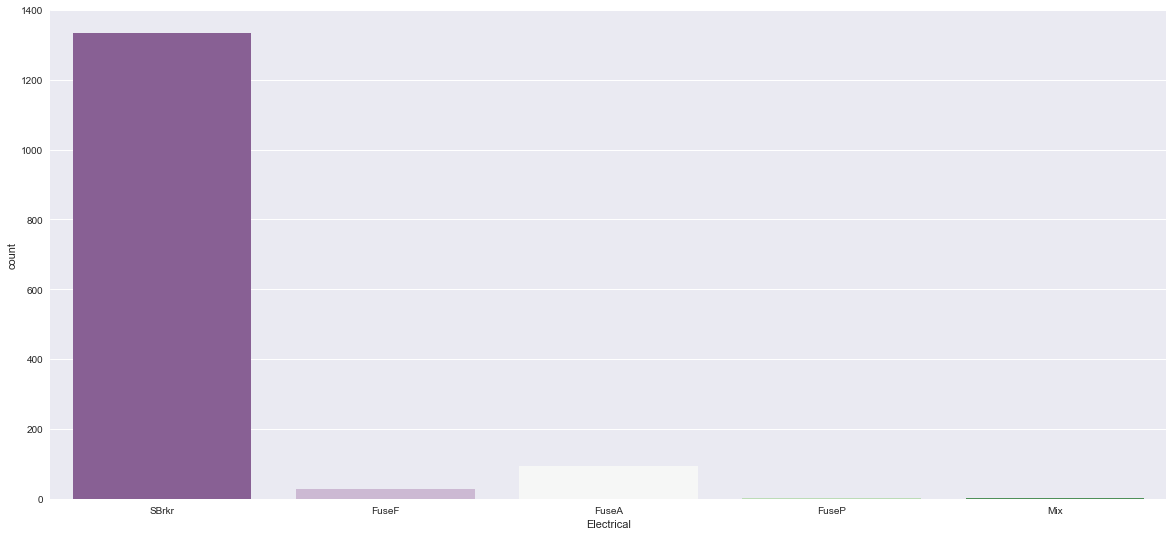

In [47]:
sns.countplot(x="Electrical", data=df, palette="PRGn");

In [48]:
df.Electrical.replace(np.nan,'SBrkr',inplace=True) #Replace with the most commun.

### LotFrontage

In [49]:
print('Values of LotFrontage ', np.unique(df.LotFrontage.dropna().values))

Values of LotFrontage  [ 21.  24.  30.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 114. 115. 116. 118. 120. 121. 122. 124. 128. 129. 130. 134. 137. 138.
 140. 141. 144. 149. 150. 152. 153. 160. 168. 174. 182. 313.]


Since it represents the linear feet of street connected to property we might want to approximate the value by the medium of all the houses. Let's plot the value of the Lot Frontage.

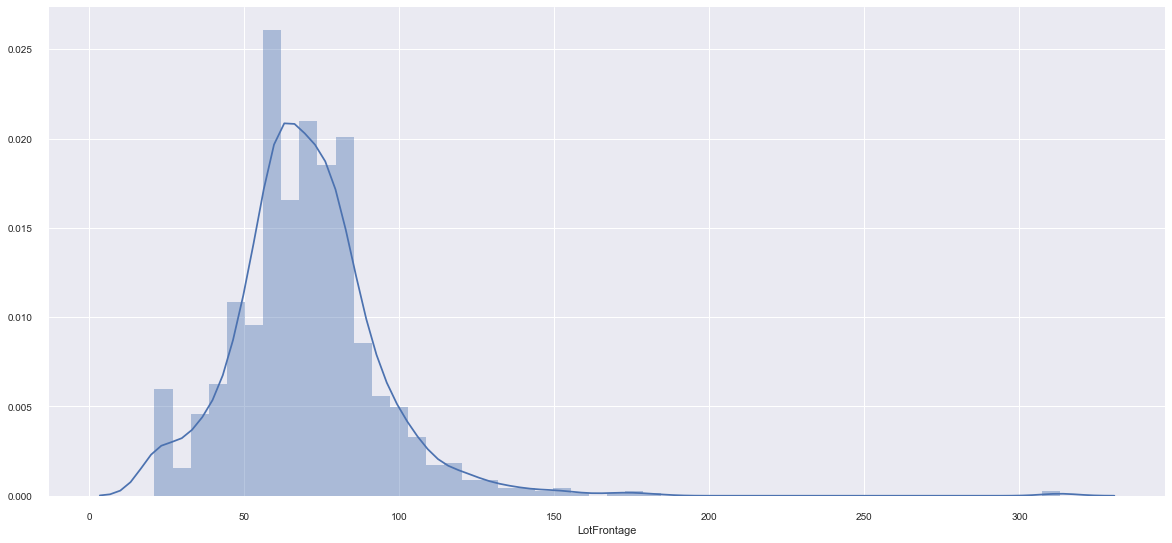

In [50]:
# Set up the matplotlib figure
sns.distplot(df.LotFrontage.dropna())
sns.despine(offset=10, trim=True)

In [51]:
df.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

We can see there are some outliers. with more than 200 LotFrontage. Maybe a more resonable way to interpret fill the data would be to use the median of the neighboorhood.

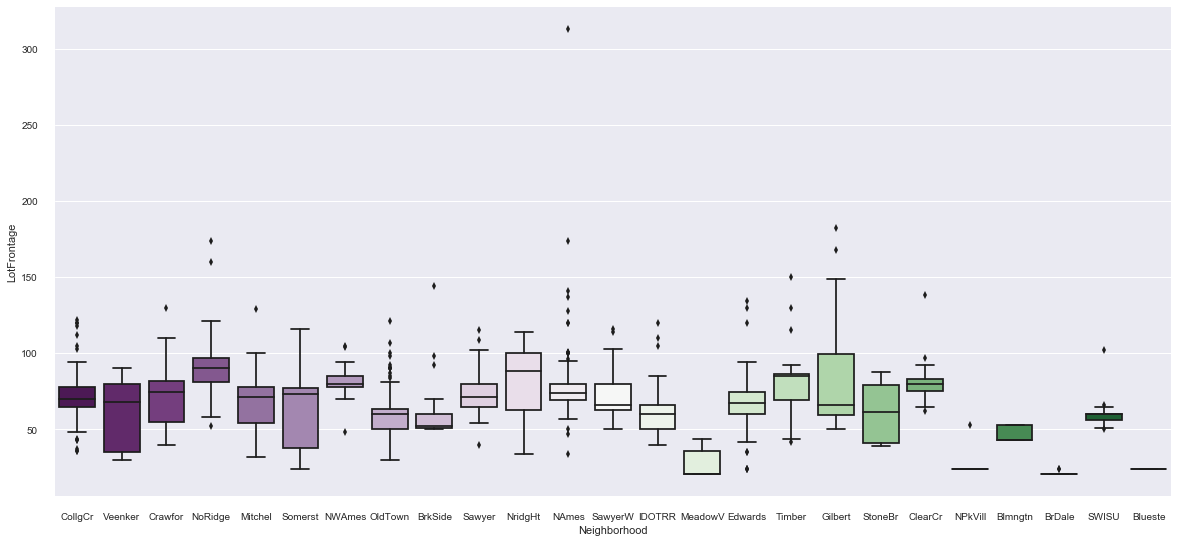

In [52]:
sns.boxplot(x="Neighborhood", y="LotFrontage", data=df_train, palette="PRGn")
sns.despine(offset=10, trim=True)

In [53]:
NeighborhoodMedianLotFrontage = {}
for n in np.unique(df.Neighborhood.values):
    NeighborhoodMedianLotFrontage[n] = df[df.Neighborhood == n].LotFrontage.dropna().median()

In [54]:
df.LotFrontage = df.apply(lambda row: NeighborhoodMedianLotFrontage[row['Neighborhood']] if np.isnan(row['LotFrontage']) else row['LotFrontage'], axis=1)

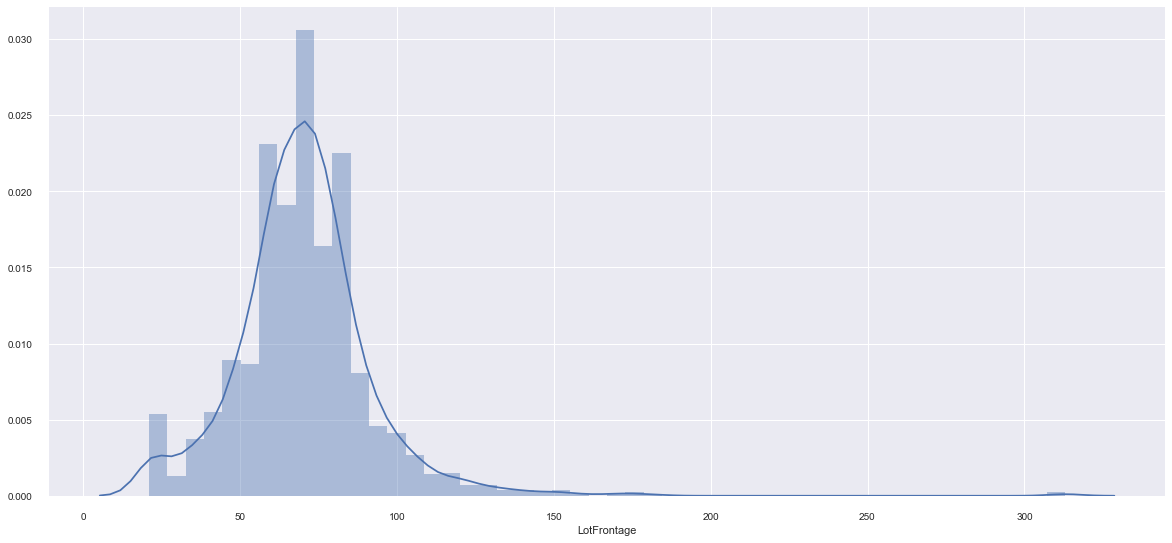

In [55]:
df.LotFrontage.dropna()
sns.distplot(df.LotFrontage.dropna())
sns.despine(offset=10, trim=True)

In [56]:
missingValues = df.isnull().sum()
print('\nTotal of missing values : ', missingValues.sum())


Total of missing values :  0


<div class="alert alert-success">


__We no longer have some missing values__.

However we've seen how for some features we might have inserted some uncertainty (eg:GarageYrBlt). Therefore we will at some point look if those features are very correlated to others in order th remove then.

</div>

## Converting grading string system to numbers

Several features of our data uses a grading system such as Poor, Fair, Great, Excellent. Let's convert it to numbers for future use. The first stage is to determine all the columns that we can transform.

In [57]:
stringGradingToNum = {'Na':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
stringGradingToNumKeys = list(stringGradingToNum.keys())
def isStringTypeConvertible(values) :
    for v in values:
        if v not in stringGradingToNumKeys:
            return False
    return True

In [58]:
col_convertible = [i for i in df.columns.to_series().groupby(df.dtypes).groups[np.dtype('O')] if isStringTypeConvertible(df[i].values)]
print("Columns that can be converted : ", col_convertible)

Columns that can be converted :  ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


In [59]:
for col in col_convertible:
    df[col] = df[col].map(lambda x: stringGradingToNum[x])

<div class="alert alert-info">


The following columns can also be converted to integers as they present some kind of rating or are binary

* Utilites
* Street
* Alley
* LandSlope
* BsmtExposure
* BsmtFinType1
* BsmtFinType2
* CentralAir
* PavedDrive
* Fence

Considering the other types of columns (int and float) some doesn't provide a ranking and therefore should be transform as categorical.

* YearBuilt*
* YearRemodAdd*
* GarageYrBlt*
* MoSold
* YrSold

(*) Means that we should transform them but if we do when we apply dummies we will have to much columns...
</div>

In [60]:
UtilitesDic = {'AllPub':1, 'NoSeWa':0}
df.Utilities = df.Utilities.apply(lambda x: UtilitesDic[x])

StreetDic = {'Grvl':1, 'Pave':0}
df.Street = df.Street.apply(lambda x: StreetDic[x])

AlleyDic = {'Na':0, 'Grvl':1, 'Pave':2}
df.Alley = df.Alley.apply(lambda x: AlleyDic[x])

LandSlopeDic = {'Gtl':0, 'Mod':1, 'Sev':2}
df.LandSlope = df.LandSlope.apply(lambda x: LandSlopeDic[x])

BsmtExposureDic = {'Na':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
df.BsmtExposure = df.BsmtExposure.apply(lambda x: BsmtExposureDic[x])

BsmtFinTypeDic = {'ALQ':5, 'BLQ':4, 'GLQ':6, 'LwQ':2, 'Na':0, 'Rec':3, 'Unf':1}
df.BsmtFinType1 = df.BsmtFinType1.apply(lambda x: BsmtFinTypeDic[x])
df.BsmtFinType2 = df.BsmtFinType2.apply(lambda x: BsmtFinTypeDic[x])

CentralAirDic = {'N':0, 'Y':1}
df.CentralAir = df.CentralAir.apply(lambda x: CentralAirDic[x])

PavedDriveDic = {'N':0, 'P':1, 'Y':2}
df.PavedDrive = df.PavedDrive.apply(lambda x: PavedDriveDic[x])

FenceDic = {'Na':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}
df.Fence = df.Fence.apply(lambda x: FenceDic[x])

In [61]:
df.YrSold = df.YrSold.astype(str)
df.MoSold = df.MoSold.astype(str)

In [62]:
# We split again the data.
SalePrice = df_train.SalePrice
df_train = df[:len(df_train)]
df_train['SalePrice'] = SalePrice
df_test = df[len(df_train):]

## Descriptive statistics about the data

<div class="alert alert-info">


In this section we will make a first visualization of the data. This will provide us a first view of the dataset.

</div>

### SalePrice (target value)

Since this is the target attribute we will consider it first.

In [63]:
df_train.SalePrice.describe()

count      1200.000000
mean     181414.628333
std       81070.908544
min       34900.000000
25%      129900.000000
50%      163700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

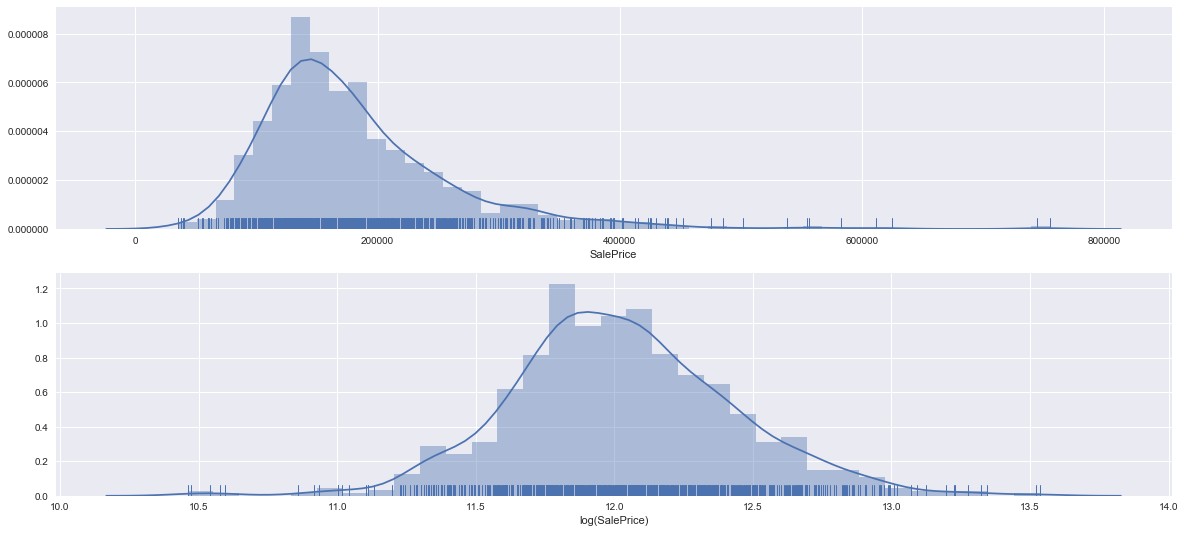

In [64]:
f, axarr = plt.subplots(2, sharex=False)
sns.distplot(df_train['SalePrice'], rug=True, ax=axarr[0]);
sns.distplot(np.log(df_train['SalePrice']), rug=True, ax=axarr[1], axlabel="log(SalePrice)");

In [65]:
df_train['logSalePrice'] = np.log(df_train.SalePrice)
df_train.drop(columns=['SalePrice'], inplace=True)

<div class="alert alert-success">

We have a few houses with a sale price above 500 000$. The log of SalePrice seems to follow a normal distributon. A normal distribution will give better result to our models, therefore we will __work only with the log(SalePrice)__ for now on.

</div>

### Correalation of the numerical values

The following output contains the 10 numerical values most correlated with the log of the sale price.

Correlation plot


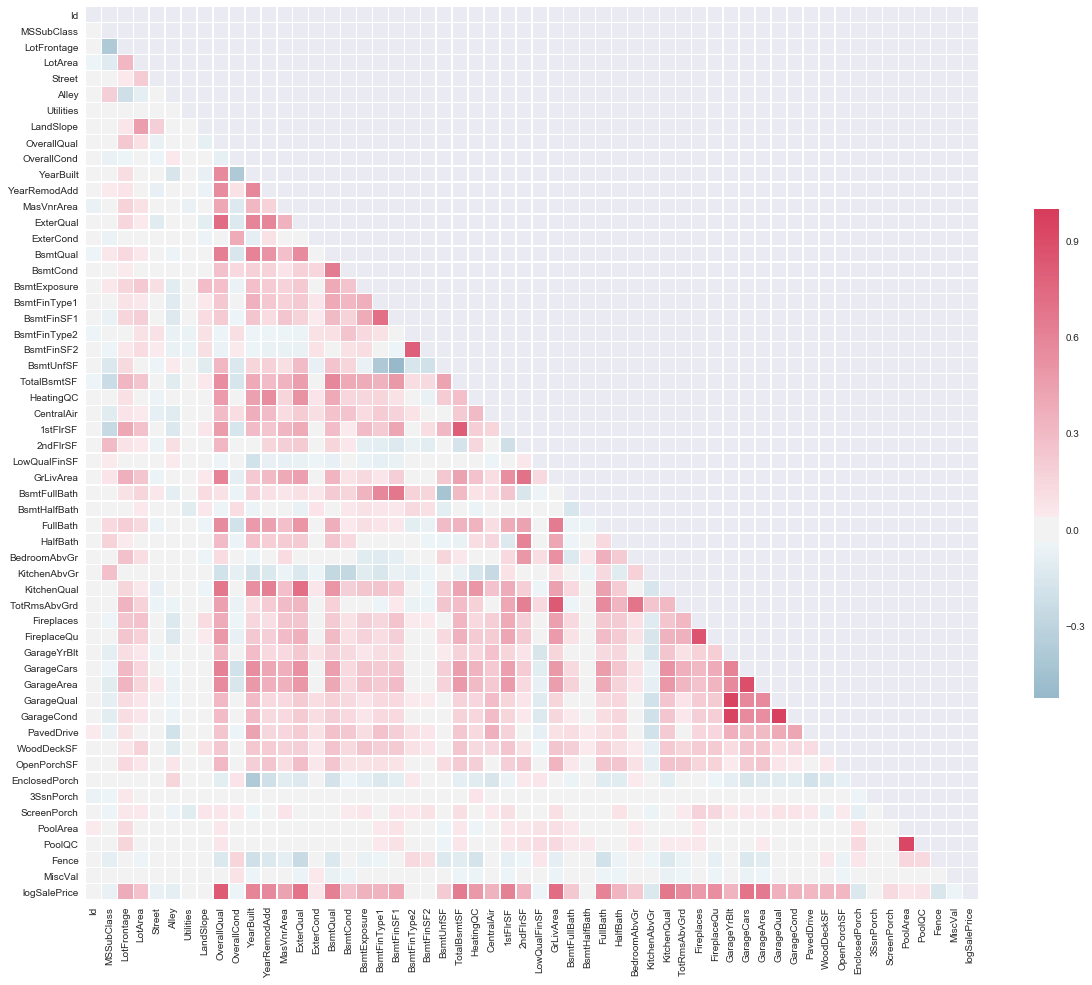

In [66]:
plotCorrelation(df_train)

<div class="alert alert-info">


Based on the fact that we want to predict SalePrice. The data we mostly want to take into account are the features most correlated with SalePrice.

</div>

In [67]:
df_train.corr().logSalePrice.sort_values(ascending=False)[1:11]

OverallQual    0.818680
GrLivArea      0.728163
GarageCars     0.681809
ExterQual      0.679259
KitchenQual    0.669033
GarageArea     0.651121
TotalBsmtSF    0.641615
BsmtQual       0.616725
1stFlrSF       0.610721
FullBath       0.607066
Name: logSalePrice, dtype: float64

<div class="alert alert-info">


Since there are a lot of attributes to consider (there are 79) we have two options :
1. Follow the order of the columns
2. Follow the order of correlation (most correlated to less correlated).

We opted for the second option. However we can't compute the correlation betweeen number and categorical value (strings). Therefore we will first consider the 10 most correlated and treat the categorical features with the rest of the nulerical value 

</div>

<div class="alert alert-danger">

__MAJOR IDEA__

   In the previous versions of this notebook we were plotting each features and removing whats seemed like obvious outliers.
   Also when we wouldn't know what to do with a Nan value we would just remove it from the training set.
   The reason for doing that was that we would drastically increase our result in CV later on. 
   However after discussing together and with Pietro Michiardi we felt like it was simply under-fitting.

Therefore a better approach is instead remove data that wont be present into in the test data.

</div>

<div class="alert alert-info">

To serve that purpose we will follow this procedure :
- Plot the __SalePrice in function of the features__ for the Train data but also the __Test data__.
- Plot the __Distribution of the features__ for the Train data but also the __Test data__.
- __List__ the points necessary to remove to make the plots match.

</div>

### OverallQual

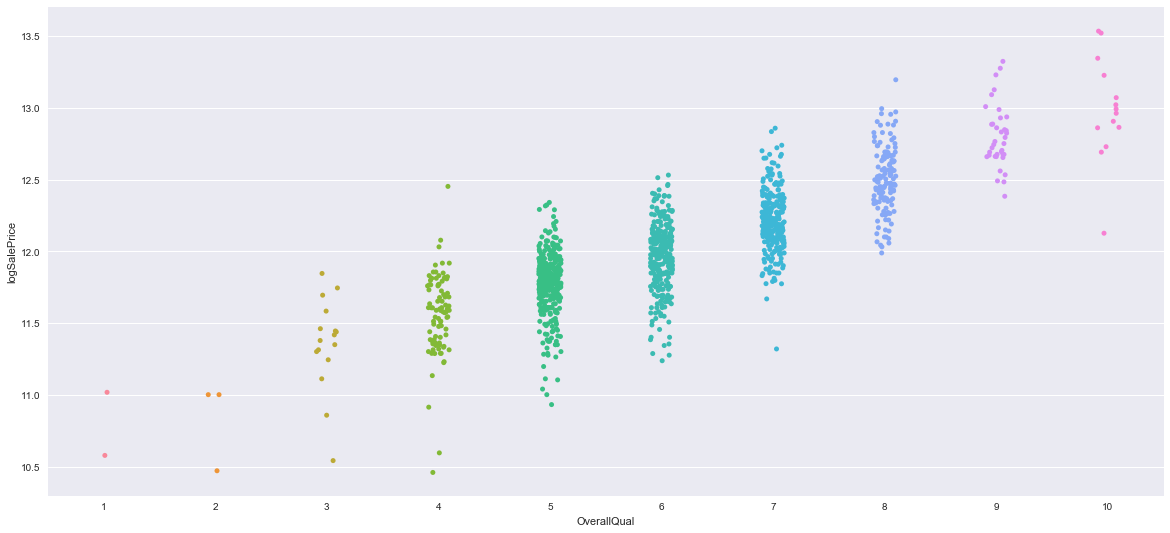

In [68]:
sns.stripplot(x=df_train.OverallQual, y=df_train.logSalePrice, jitter=True);

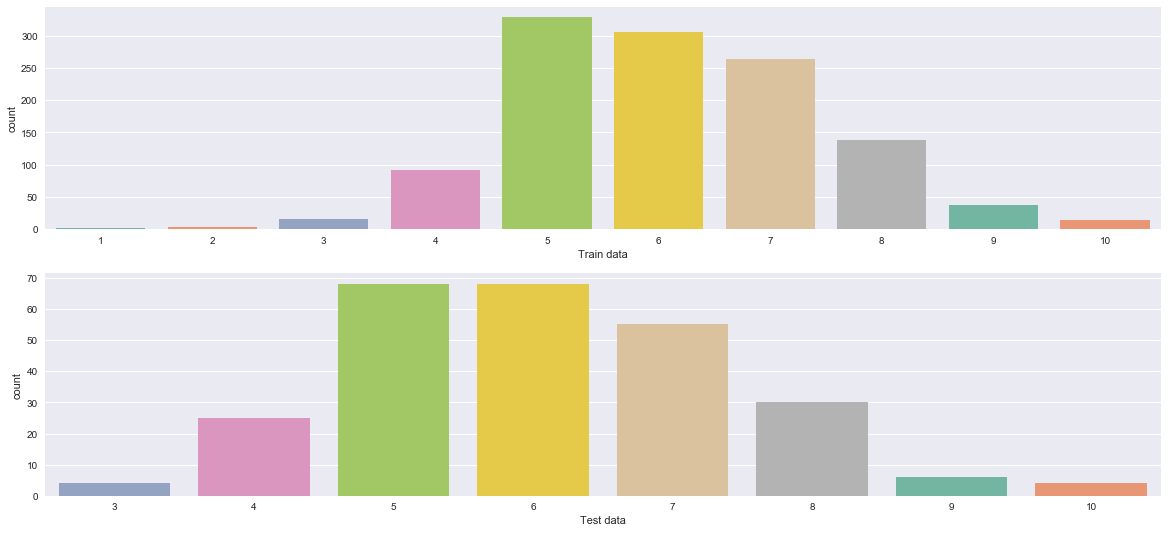

In [69]:
palette = sns.color_palette("Set2", 10)
f, axarr = plt.subplots(2, sharex=False)
sns.countplot(x="OverallQual", data=df_train, ax=axarr[0], palette=palette);
axarr[0].set_xlabel(xlabel="Train data")
sns.countplot(x="OverallQual", data=df_test, ax=axarr[1], palette=palette[2:]);
axarr[1].set_xlabel('Test data');

<div class="alert alert-success">
__Observations__

We notice immediately that OverallQuality on the test data doesn't contains 1 or 2 unlike train data. We will keep it in mind by saving the indexes of the houses with OverallQual equal to 1 or 2, it might helps us clean our data. Indeed it is useless to train a model on data that we won't be predicting. However this isn't the only thing we notice: the repartion of the overall quality is very similar on both datasets.
</div>

In [70]:
IndexesToClean['OverallQual'] = {'non representative':list(df_train[df_train.OverallQual <= 2].Id), 'outliers':[969,31,458,496,633,524]}

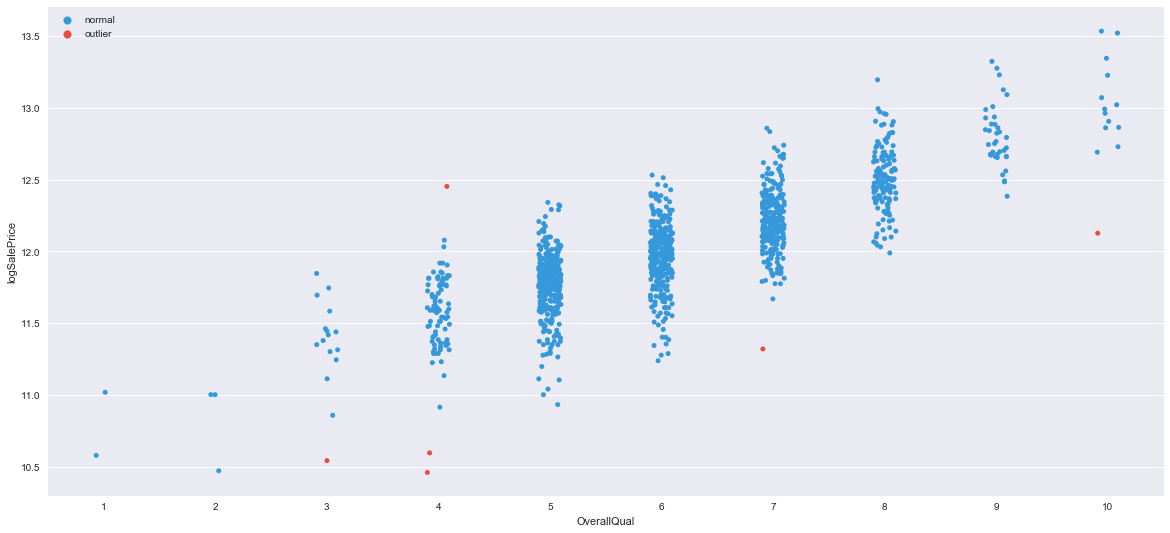

In [71]:
hue=['normal']*df_train.shape[0]
for i in IndexesToClean['OverallQual']['outliers'] :
    hue[i-1]='outlier'
sns.stripplot(x=df_train.OverallQual, y=df_train.logSalePrice, hue=hue, jitter=True, palette=["#3498db", "#e74c3c"]);

### GrLivArea

As we did for SalePrice we will replace GrLivArea by log(GrLivArea).

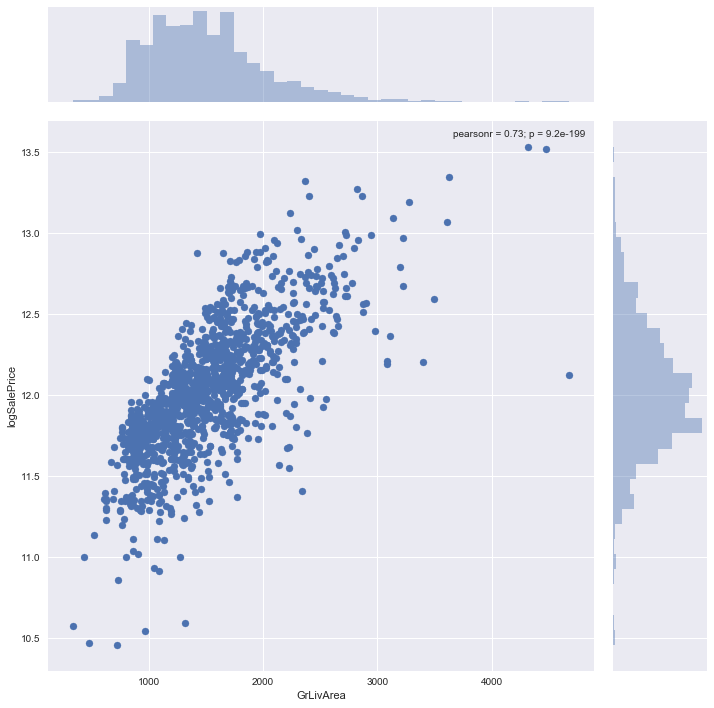

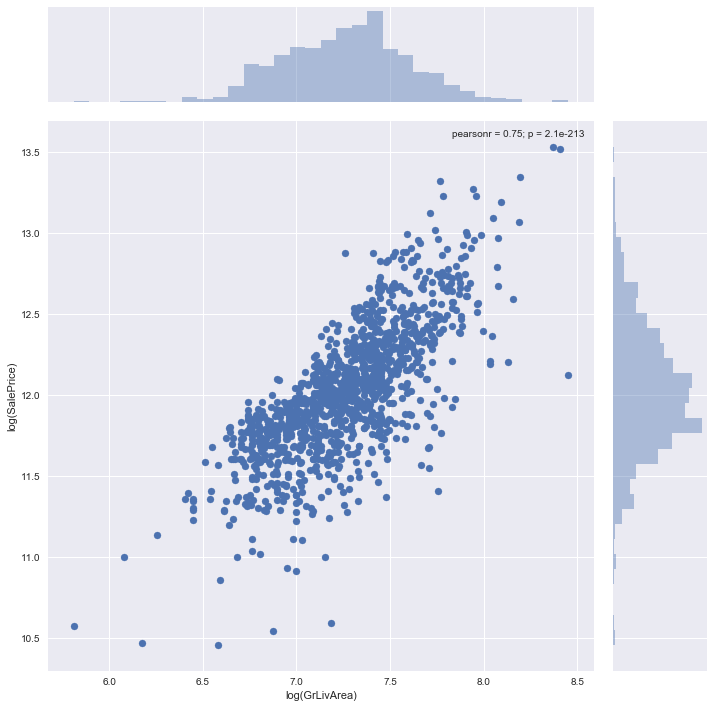

In [72]:
jp1 = sns.jointplot(x="GrLivArea", y="logSalePrice", data=df_train, size=10);
jp2 = sns.jointplot(x=np.log(df_train.GrLivArea), y=df_train.logSalePrice, size=10, );
jp2.set_axis_labels('log(GrLivArea)','log(SalePrice)');

In [73]:
logGrLivArea_train = np.log(df_train.GrLivArea)
df_train.drop(columns=['GrLivArea'], inplace=True)
df_train['logGrLivArea'] = logGrLivArea_train
logGrLivArea_test = np.log(df_test.GrLivArea)
df_test.drop(columns=['GrLivArea'], inplace=True)
df_test['logGrLivArea'] = logGrLivArea_test

Now we will put the outliers in the IndexesToClean dictionnary and we will plot them alongside the 'normal' data.

In [74]:
IndexesToClean['logGrLivArea'] = {'outliers':list(df_train[((df_train.logGrLivArea>6.75) & (df_train.logSalePrice<10.75)) | ((df_train.logGrLivArea>8.25) & (df_train.logSalePrice<12.5))].Id)}

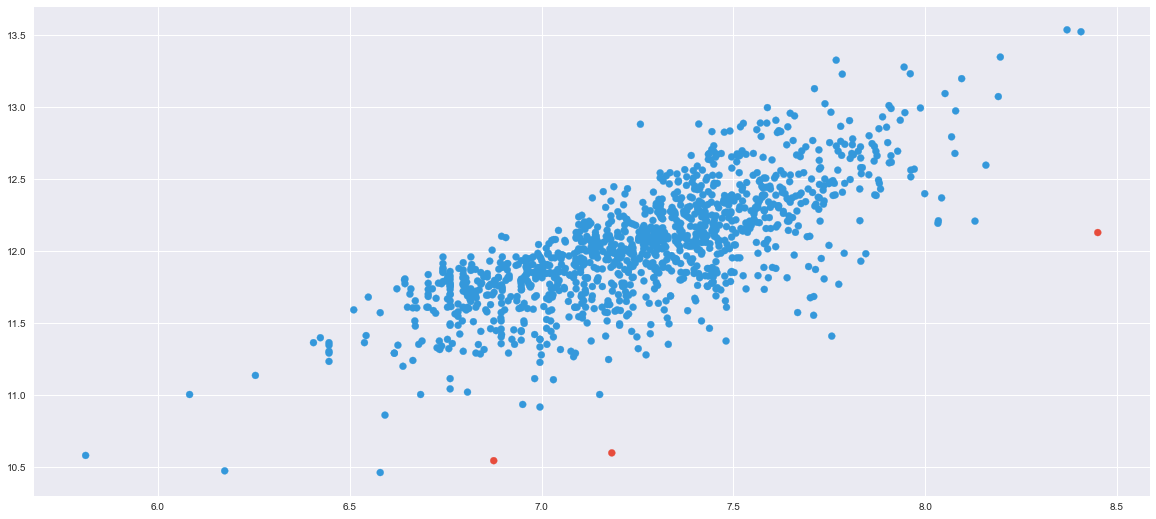

In [75]:
c=['#3498db']*df_train.shape[0]
for i in IndexesToClean['logGrLivArea']['outliers'] :
    c[i-1]='#e74c3c'
plt.scatter(x=df_train.logGrLivArea, y=df_train.logSalePrice, c=c);

The following plot represents the distribution log(GrLivArea) for both the train and the test dataset. 

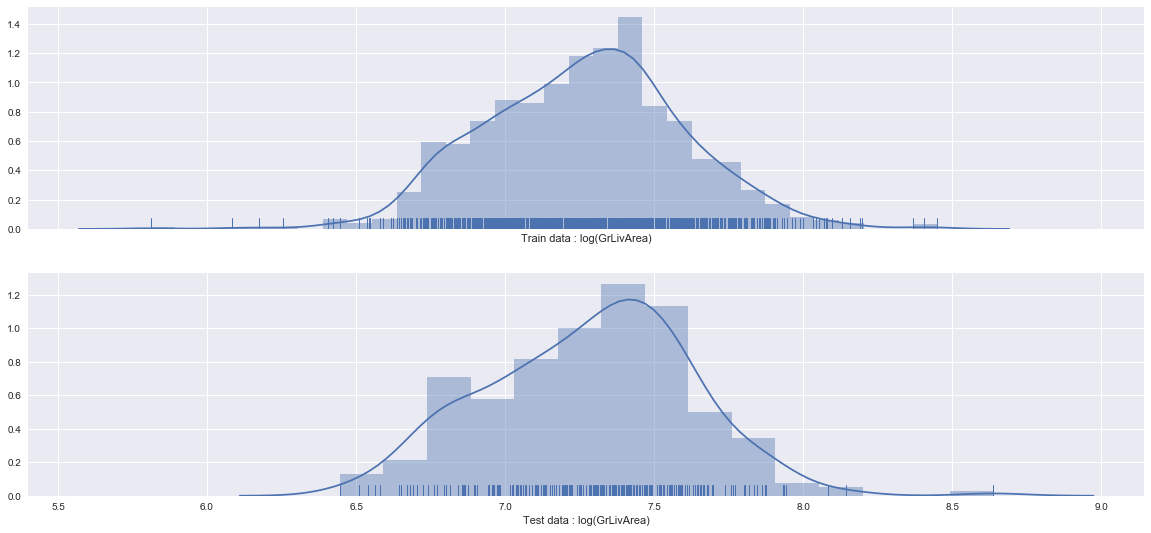

In [76]:
f, axarr = plt.subplots(2, sharex=True)
sns.distplot(df_train.logGrLivArea, rug=True, ax=axarr[0], axlabel="Train data : log(GrLivArea)");
sns.distplot(df_test.logGrLivArea, rug=True, ax=axarr[1], axlabel="Test data : log(GrLivArea)");

<div class="alert alert-success">
__Observations__

We identify a very big GrLivArea in the test data therefore we need to keep what looks like outlier in the right side of the train data plot. However the 4 houses with log(GrLivArea) < 6.3 are not representative.
</div>

In [77]:
IndexesToClean['logGrLivArea']['non-representative'] = list(df_train[df_train.logGrLivArea < 6.3].Id)

### GarageCars

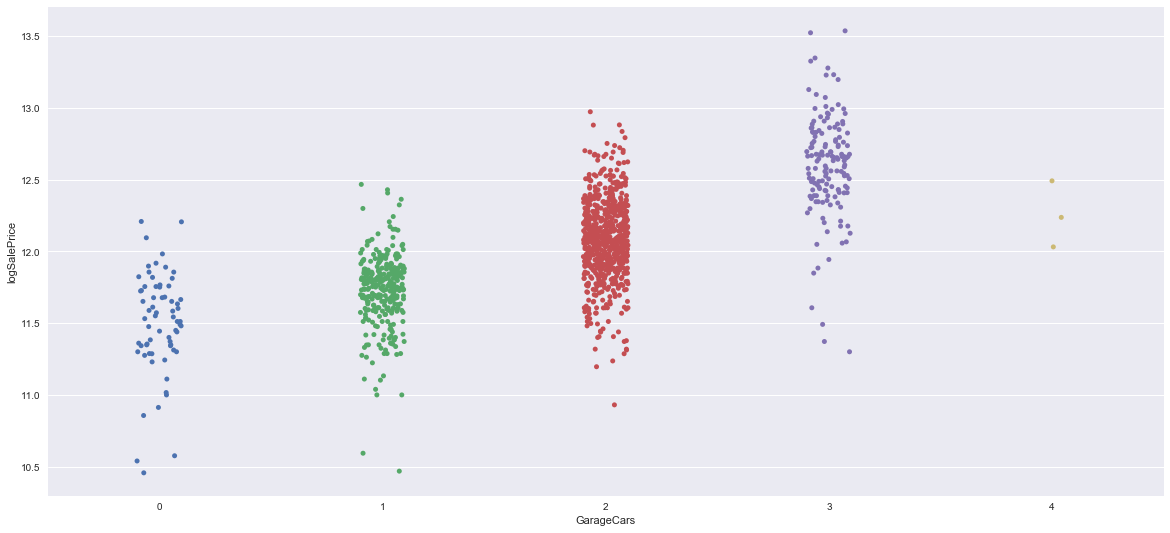

In [78]:
sns.stripplot(x=df_train.GarageCars, y=df_train.logSalePrice, jitter=True);

In [79]:
IndexesToClean['GarageCars'] = {'outliers':[31, 457, 496, 534, 677, 813, 917, 969, 1062]}

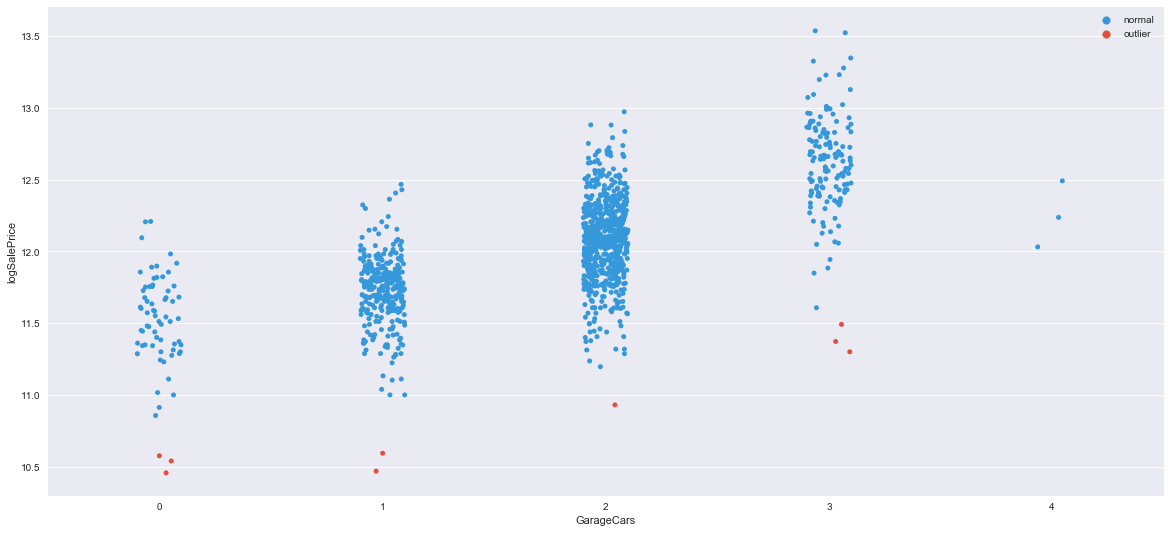

In [80]:
hue=['normal']*df_train.shape[0]
for i in IndexesToClean['GarageCars']['outliers'] :
    hue[i-1]='outlier'
sns.stripplot(x=df_train.GarageCars, y=df_train.logSalePrice, hue=hue, jitter=True, palette=["#3498db", "#e74c3c"]);

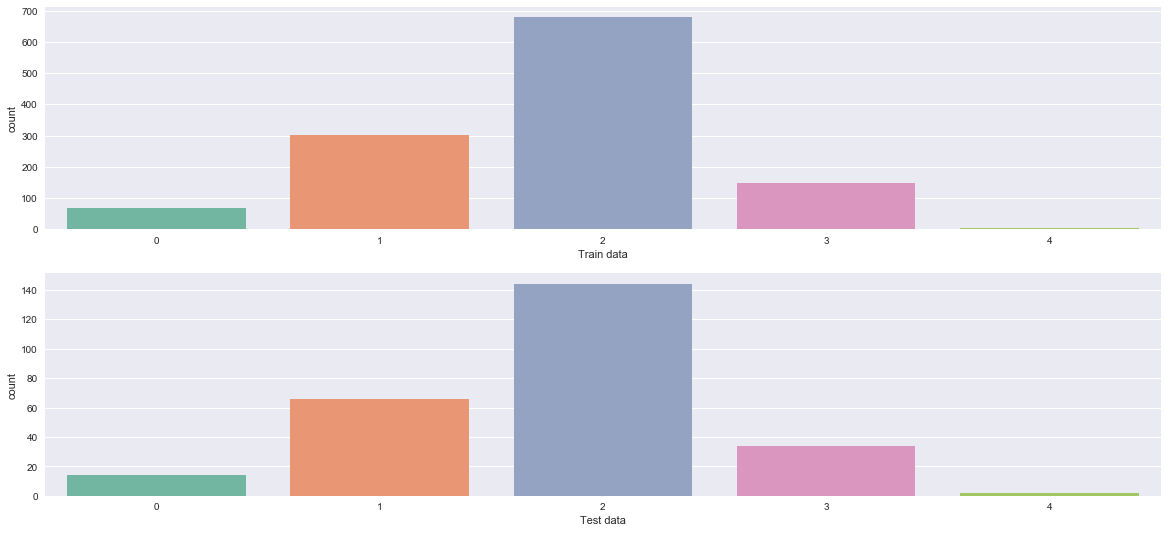

In [81]:
f, axarr = plt.subplots(2, sharex=False)
sns.countplot(x="GarageCars", data=df_train, ax=axarr[0], palette=palette);
axarr[0].set_xlabel(xlabel="Train data")
sns.countplot(x="GarageCars", data=df_test, ax=axarr[1], palette=palette);
axarr[1].set_xlabel('Test data');

<div class="alert alert-success">
__OBSERVATIONS__

The distribution is very similar between the two datasets. An idea here might be to merge 3 and 4 to create a more than 3 columns, this makes sense because of the small number of 4 (3 in the train data and 2 in the test) but also because the SoldPrice is quite similar.
</div>

### ExterQual

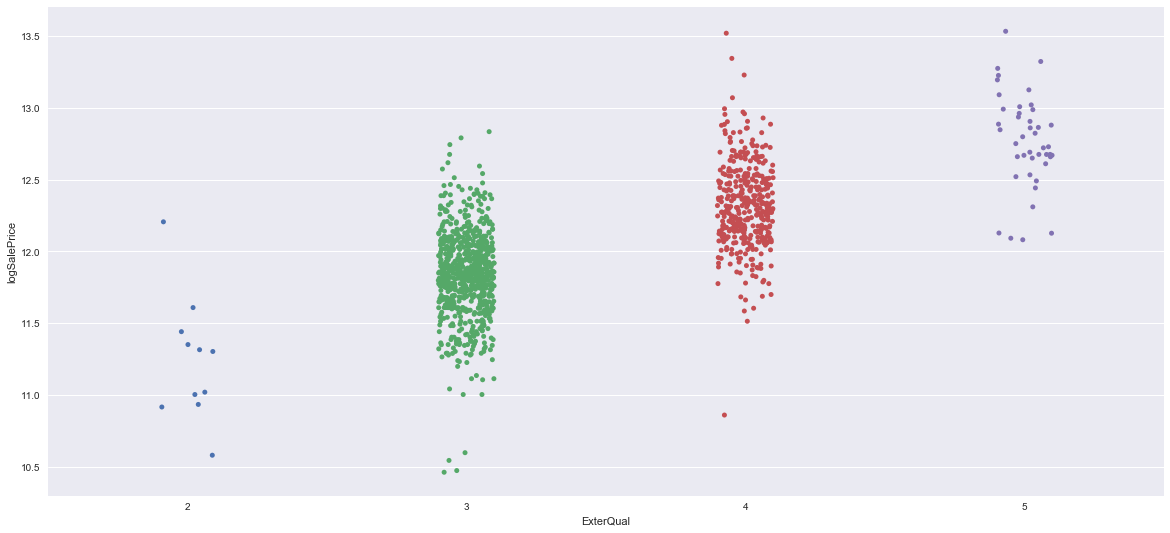

In [82]:
sns.stripplot(x=df_train.ExterQual, y=df_train.logSalePrice, jitter=True);

In [83]:
IndexesToClean['ExterQual'] = {'outliers':[636,31,496,917,969,711,1047,1170,1183]}

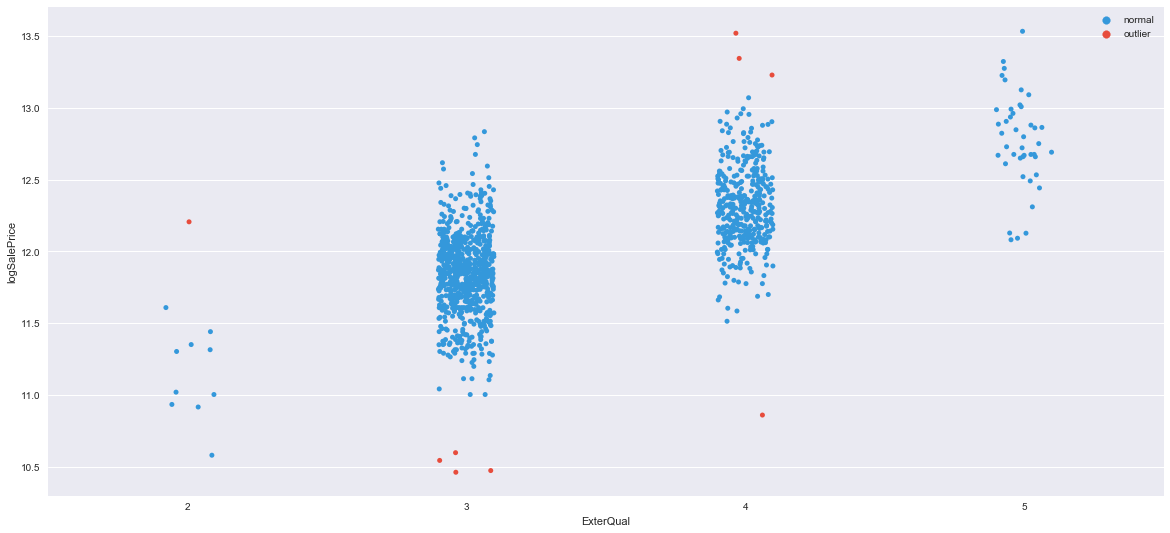

In [84]:
hue=['normal']*df_train.shape[0]
for i in IndexesToClean['ExterQual']['outliers'] :
    hue[i-1]='outlier'
sns.stripplot(x=df_train.ExterQual, y=df_train.logSalePrice, hue=hue, jitter=True, palette=["#3498db", "#e74c3c"]);

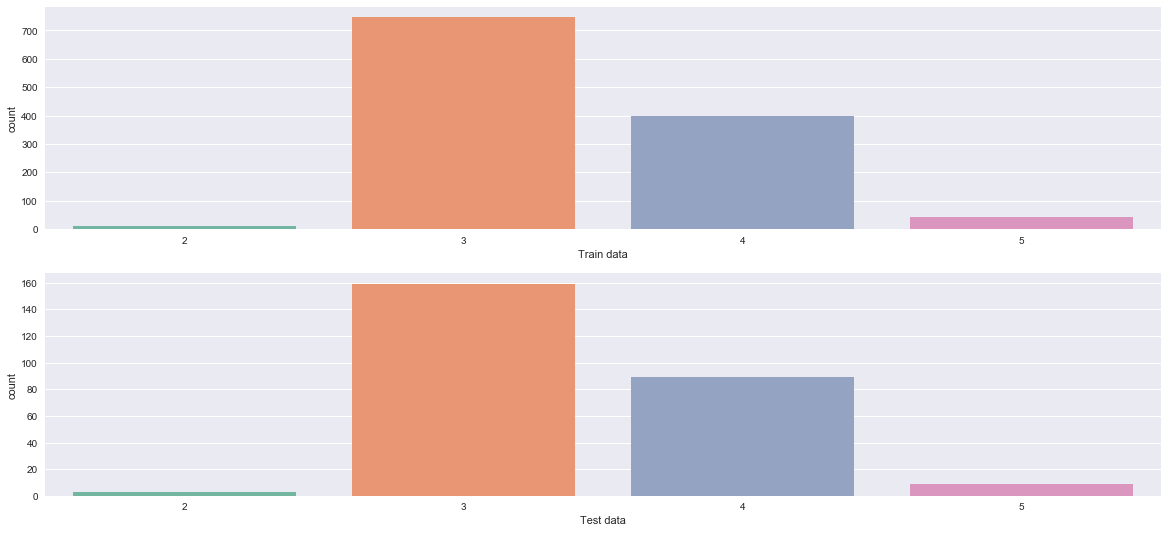

In [85]:
palette = sns.color_palette("Set2", 10)
f, axarr = plt.subplots(2, sharex=False)
sns.countplot(x="ExterQual", data=df_train, ax=axarr[0], palette=palette);
axarr[0].set_xlabel(xlabel="Train data")
sns.countplot(x="ExterQual", data=df_test, ax=axarr[1], palette=palette);
axarr[1].set_xlabel('Test data');

<div class="alert alert-success">
__Observations__

The distribution is similar between both datasets, this is great.
</div>

### KitchenQual

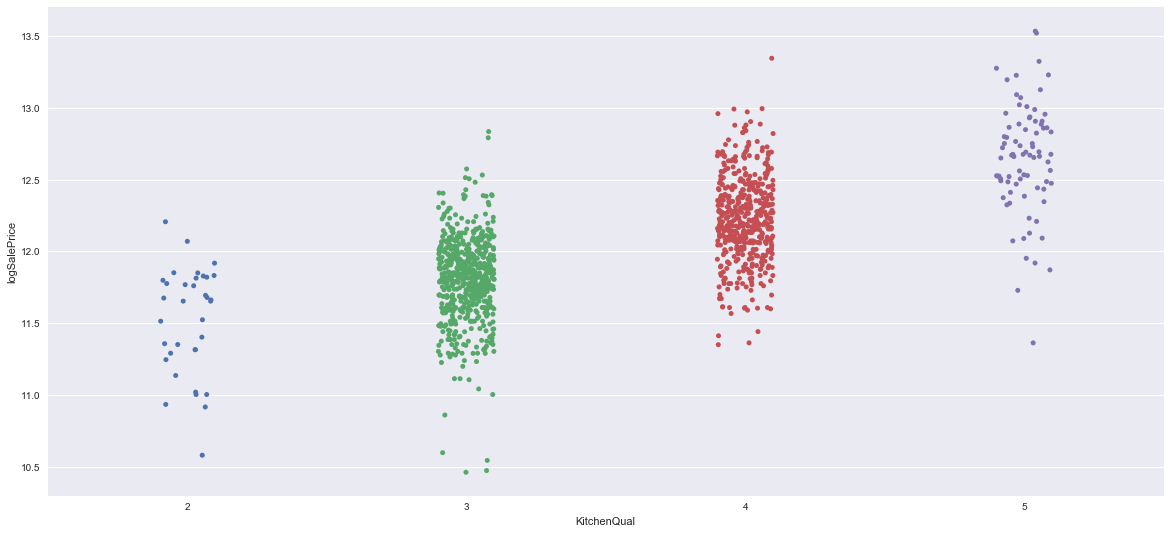

In [86]:
sns.stripplot(x=df_train.KitchenQual, y=df_train.logSalePrice, jitter=True);

In [87]:
IndexesToClean['KitchenQual'] = {'outliers':[1002,1170,314,609,692,1183,31, 496, 534, 917, 969]}

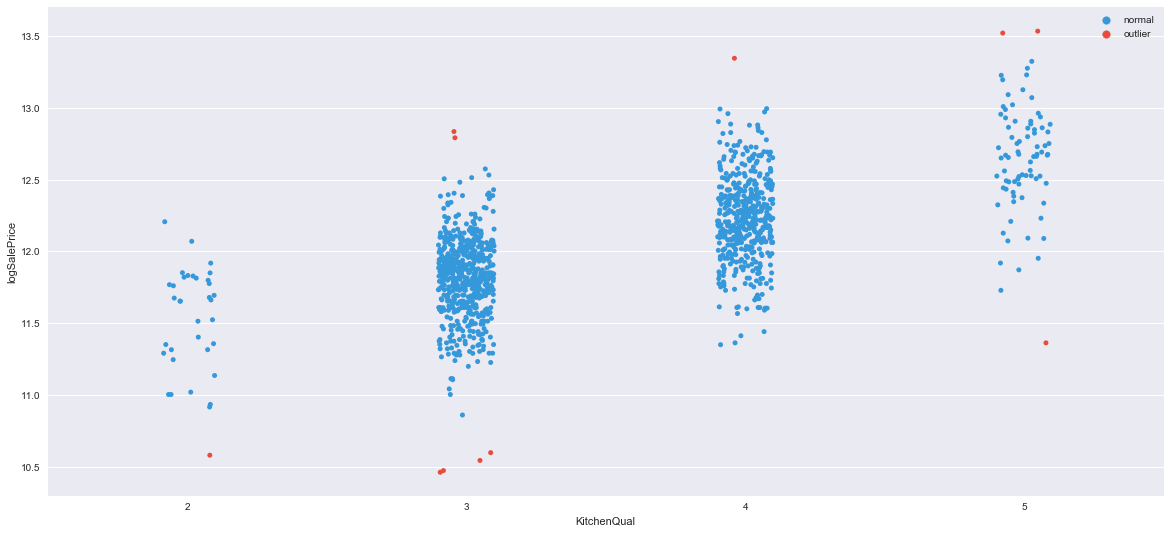

In [88]:
hue=['normal']*df_train.shape[0]
for i in IndexesToClean['KitchenQual']['outliers'] :
    hue[i-1]='outlier'
sns.stripplot(x=df_train.KitchenQual, y=df_train.logSalePrice, hue=hue, jitter=True, palette=["#3498db", "#e74c3c"]);

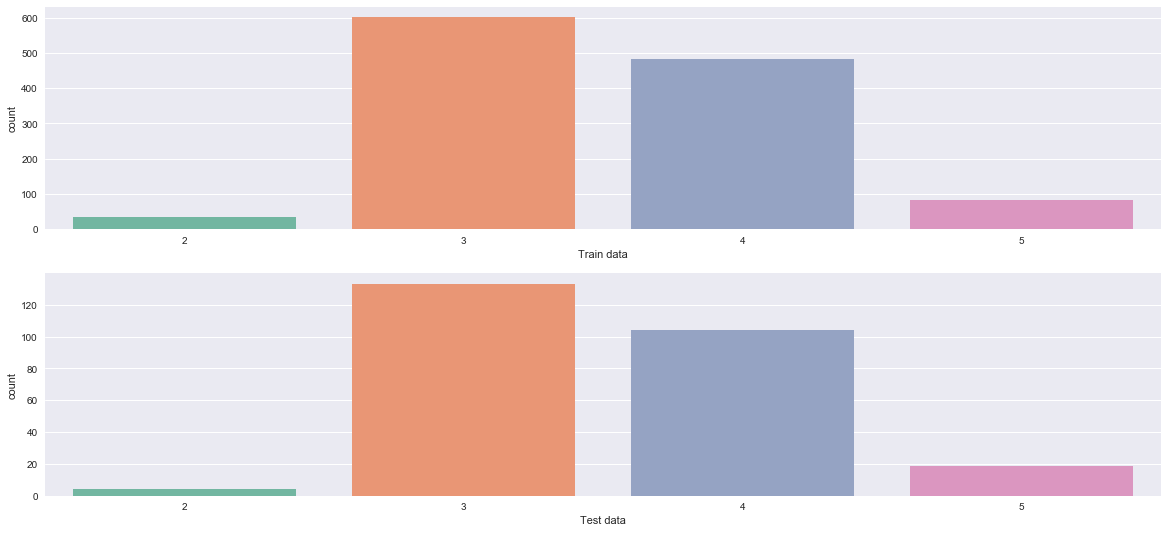

In [89]:
palette = sns.color_palette("Set2", 10)
f, axarr = plt.subplots(2, sharex=False)
sns.countplot(x="KitchenQual", data=df_train, ax=axarr[0], palette=palette);
axarr[0].set_xlabel(xlabel="Train data")
sns.countplot(x="KitchenQual", data=df_test, ax=axarr[1], palette=palette);
axarr[1].set_xlabel('Test data');

<div class="alert alert-success">
__Observations__

The distribution is similar between both datasets, this is great.
</div>

### GarageArea

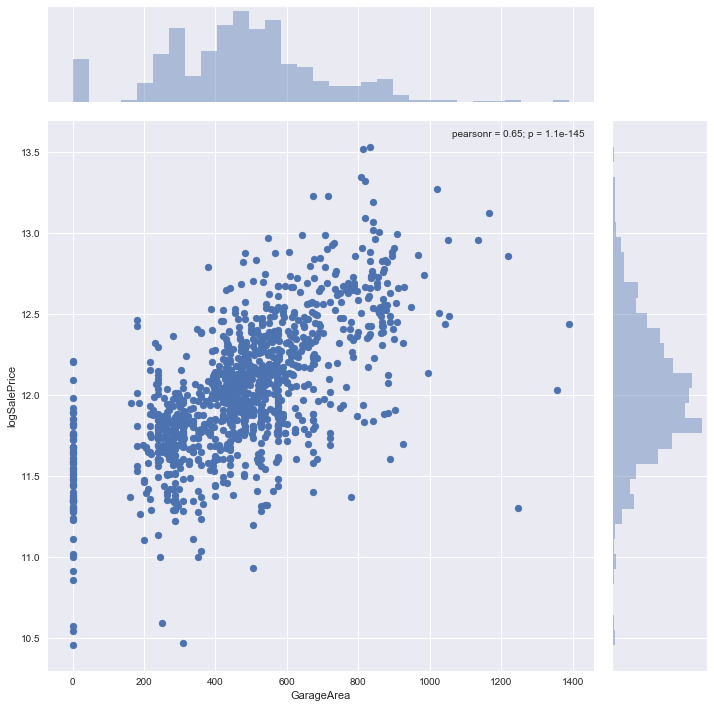

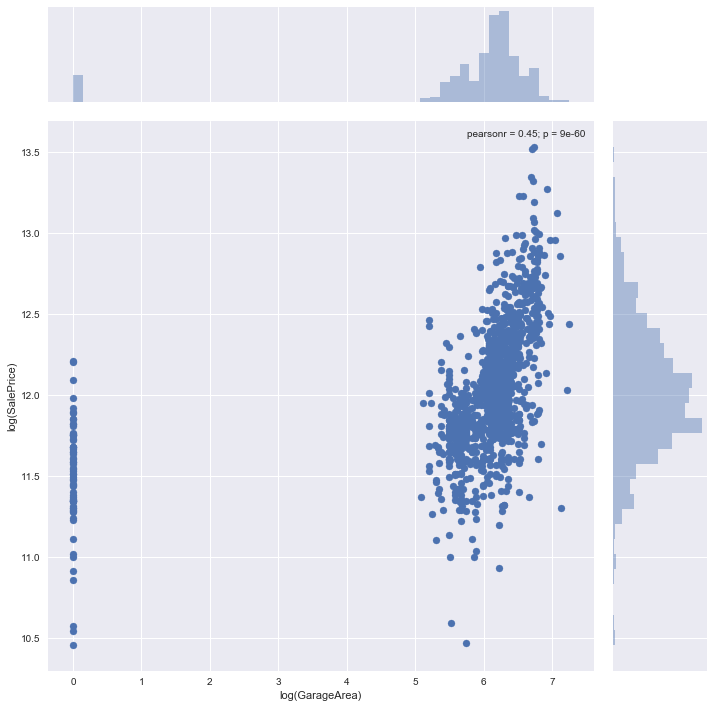

In [90]:
jp1 = sns.jointplot(x="GarageArea", y="logSalePrice", data=df_train, size=10);
jp2 = sns.jointplot(x=np.log(1+df_train.GarageArea), y=df_train.logSalePrice, size=10, );
jp2.set_axis_labels('log(GarageArea)','log(SalePrice)');

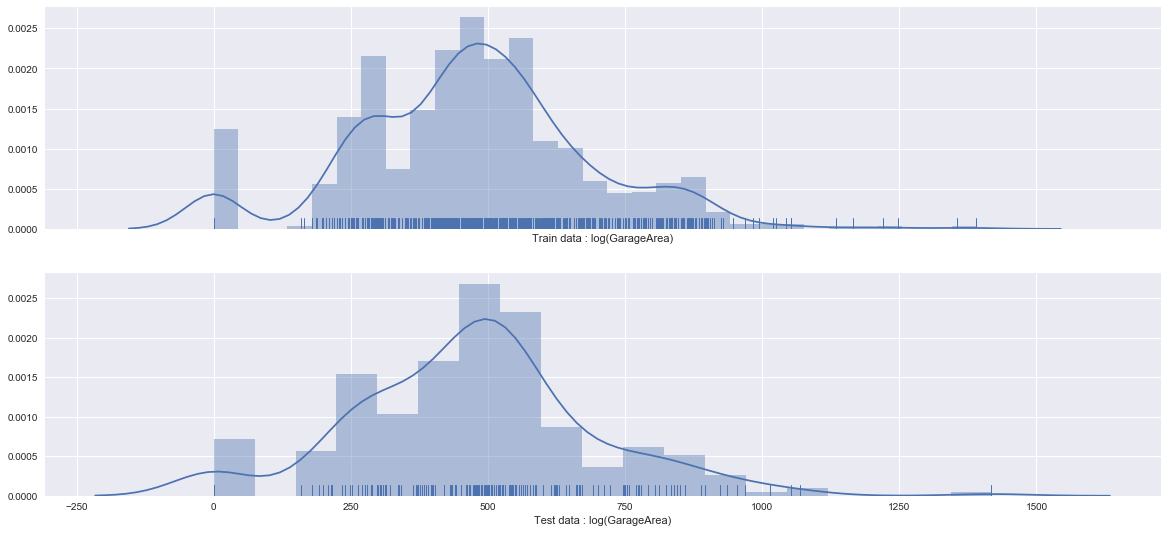

In [91]:
f, axarr = plt.subplots(2, sharex=True)
sns.distplot(df_train.GarageArea, rug=True, ax=axarr[0], axlabel="Train data : log(GarageArea)");
sns.distplot(df_test.GarageArea, rug=True, ax=axarr[1], axlabel="Test data : log(GarageArea)");

<div class="alert alert-success">

__OBSERVATION__

What's to notice here is :
- 3 times more houses without garage in train than in test
- We have a house with a very large garage in test so removing some house with large garage thinking they are outliers seems a bad idea

</div>

### TotalBsmtSF

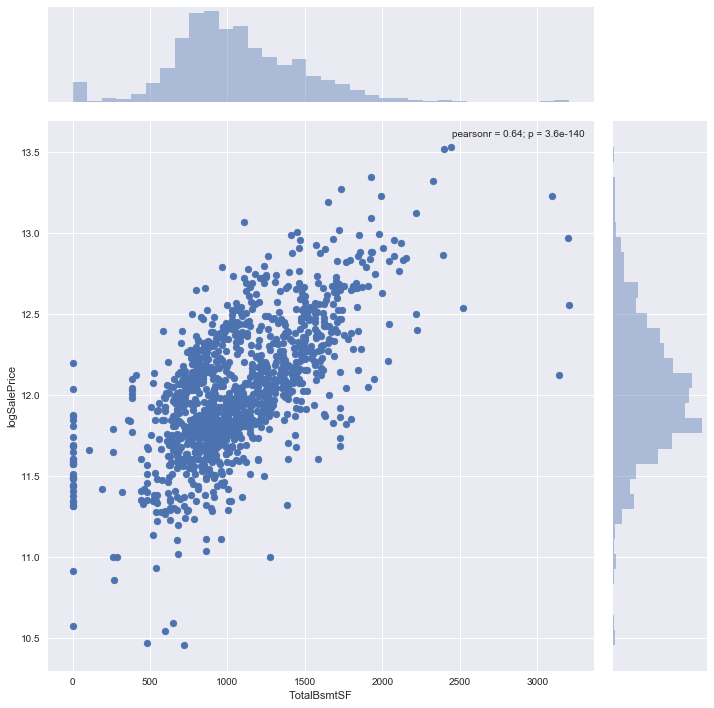

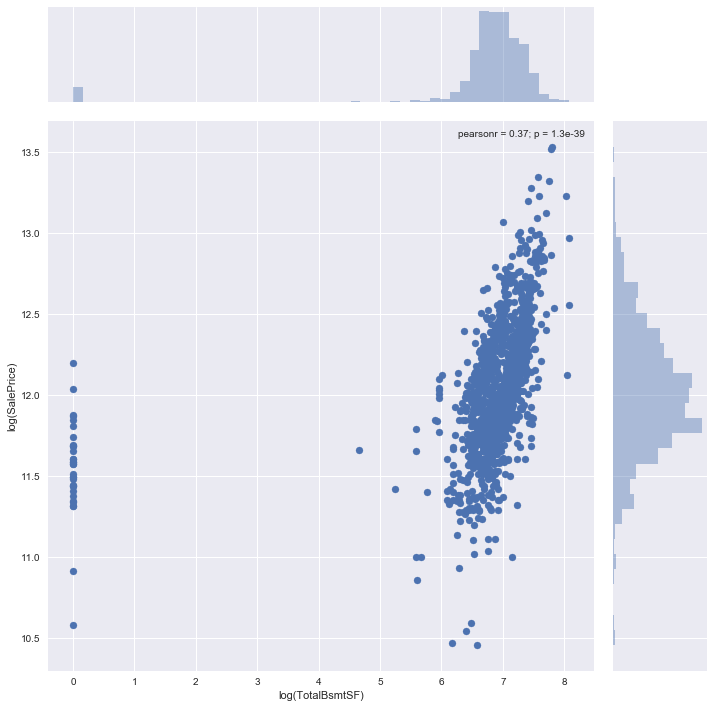

In [92]:
jp1 = sns.jointplot(x="TotalBsmtSF", y="logSalePrice", data=df_train, size=10);
jp2 = sns.jointplot(x=np.log(1+df_train.TotalBsmtSF), y=df_train.logSalePrice, size=10, );
jp2.set_axis_labels('log(TotalBsmtSF)','log(SalePrice)');

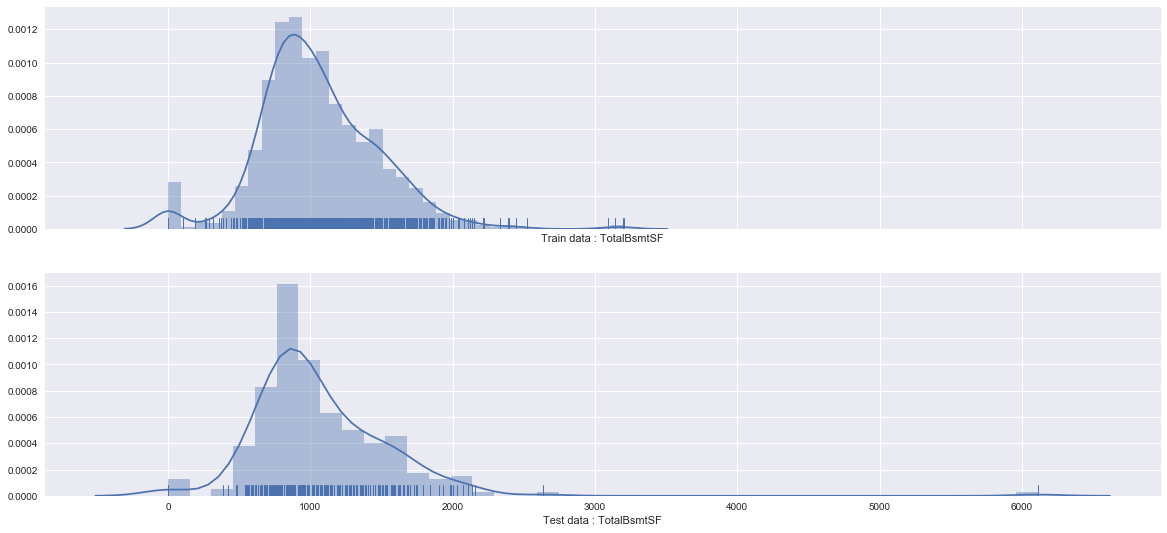

In [93]:
f, axarr = plt.subplots(2, sharex=True)
sns.distplot(df_train.TotalBsmtSF, rug=True, ax=axarr[0], axlabel="Train data : TotalBsmtSF");
sns.distplot(df_test.TotalBsmtSF, rug=True, ax=axarr[1], axlabel="Test data : TotalBsmtSF");

<div class="alert alert-success">

__OBSERVATION__

What's to notice here is how we have a huge outlier in Test data that will probably generate a big error based on the fact we do not have a single similar house.

Moreover adding a features _Total Surface_ seems like a good idea. Indeed supposing no matter the floor having surface has the same impact on the Sale price we might end up with house with similar total surface and then reduce the chances of a bad prediction

</div>

### BsmtQual

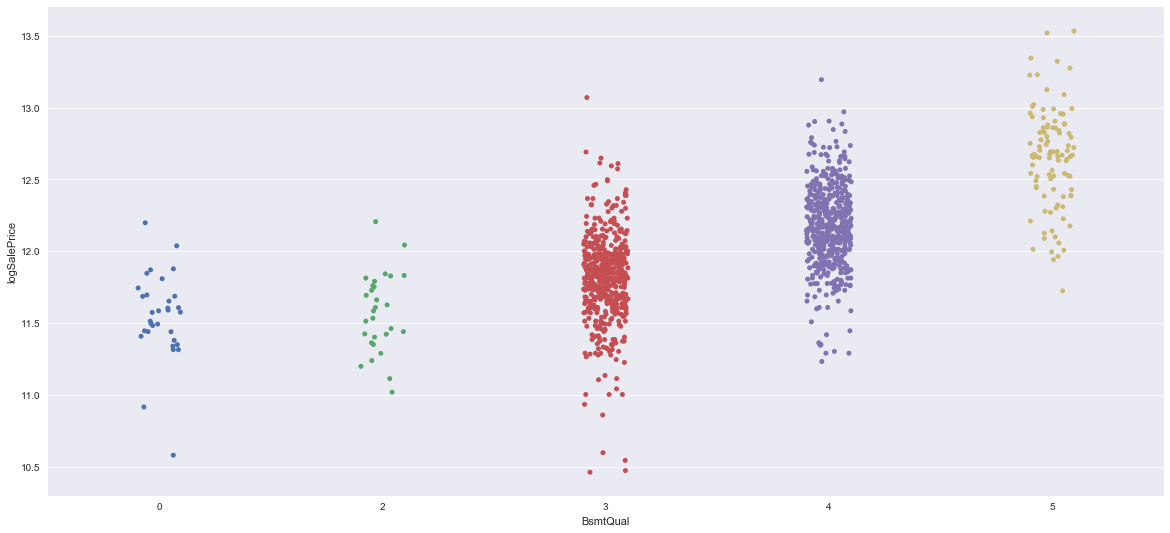

In [94]:
sns.stripplot(x=df_train.BsmtQual, y=df_train.logSalePrice, jitter=True);

In [95]:
IndexesToClean['BsmtQual'] = {'outliers':[692, 1183, 770, 186, 31, 496, 917, 969, 534, 706]}

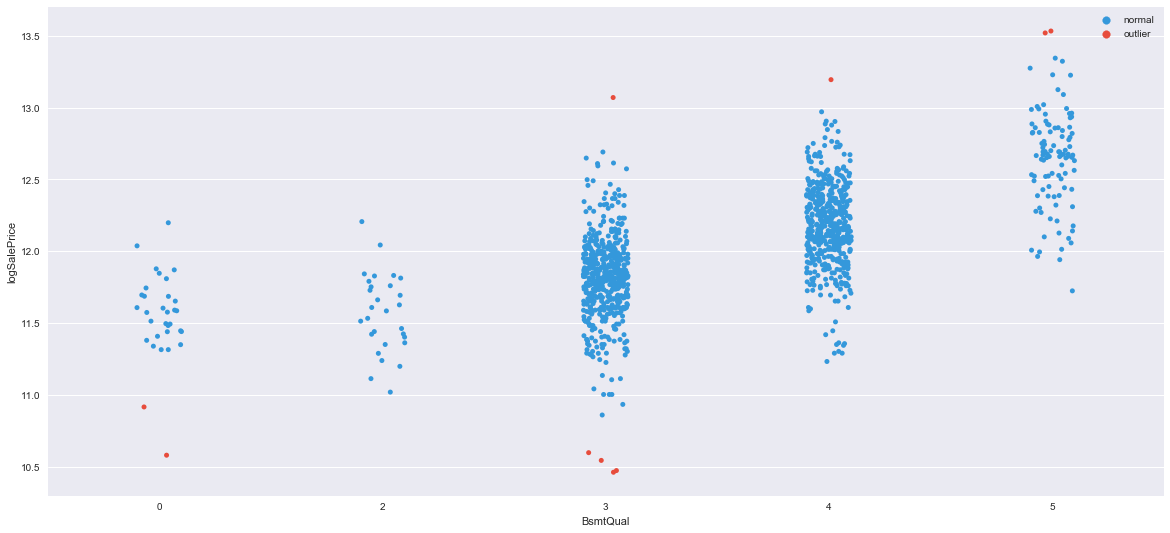

In [96]:
hue=['normal']*df_train.shape[0]
for i in IndexesToClean['BsmtQual']['outliers'] :
    hue[i-1]='outlier'
sns.stripplot(x=df_train.BsmtQual, y=df_train.logSalePrice, hue=hue, jitter=True, palette=["#3498db", "#e74c3c"]);

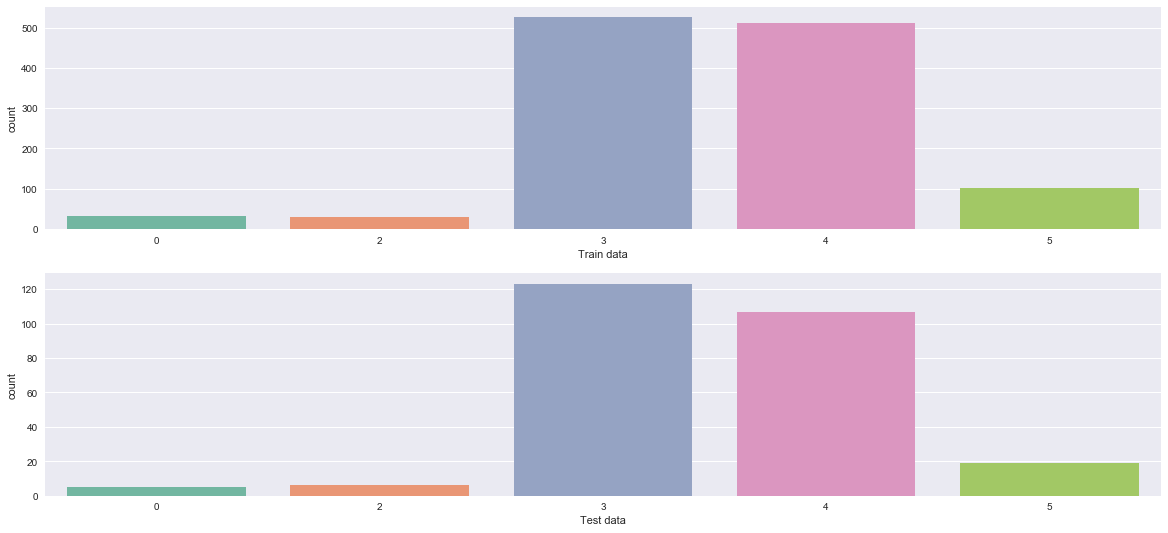

In [97]:
palette = sns.color_palette("Set2", 10)
f, axarr = plt.subplots(2, sharex=False)
sns.countplot(x="BsmtQual", data=df_train, ax=axarr[0], palette=palette);
axarr[0].set_xlabel(xlabel="Train data")
sns.countplot(x="BsmtQual", data=df_test, ax=axarr[1], palette=palette);
axarr[1].set_xlabel('Test data');

<div class="alert alert-success">
__Observations__

The distribution is similar between both datasets, this is great.
</div>

### 1stFlrSF

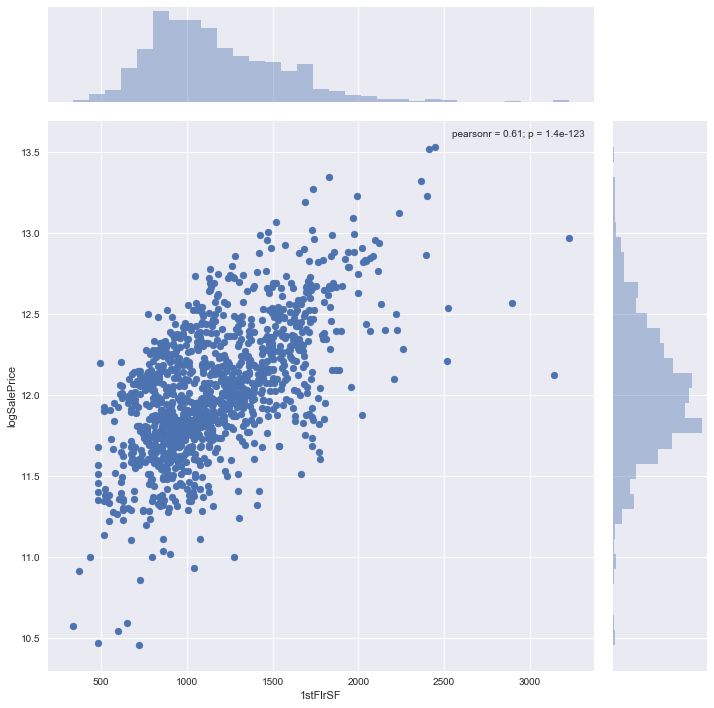

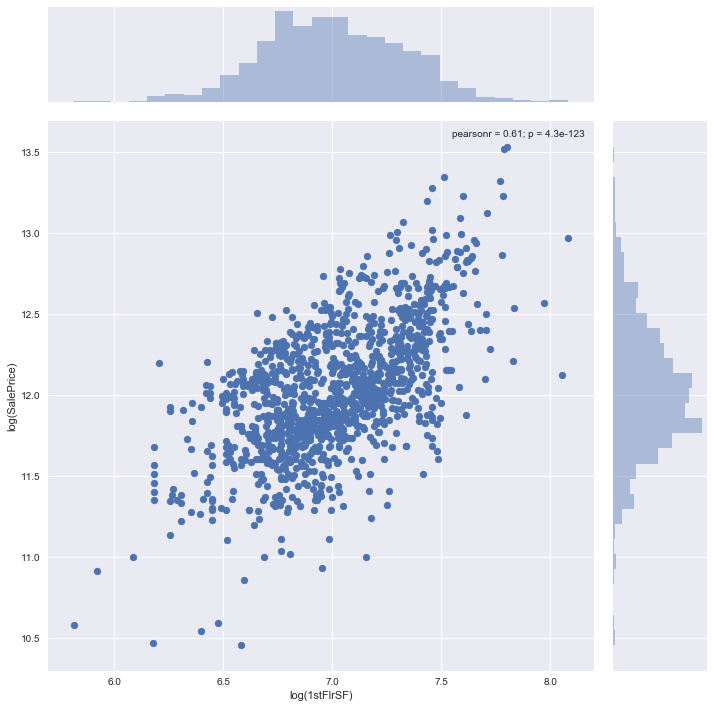

In [98]:
jp1 = sns.jointplot(x="1stFlrSF", y="logSalePrice", data=df_train, size=10);
jp2 = sns.jointplot(x=np.log(1+df_train['1stFlrSF']), y=df_train.logSalePrice, size=10, );
jp2.set_axis_labels('log(1stFlrSF)','log(SalePrice)');

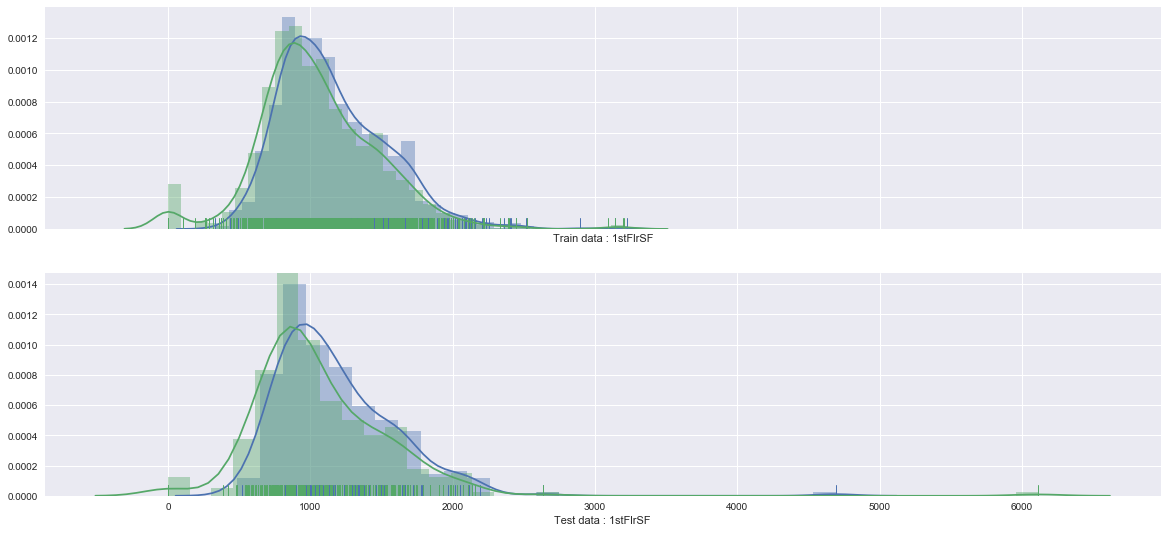

In [99]:
f, axarr = plt.subplots(2, sharex=True)
sns.distplot(df_train['1stFlrSF'], rug=True, ax=axarr[0], axlabel="Train data : 1stFlrSF");
sns.distplot(df_train['TotalBsmtSF'], rug=True, ax=axarr[0], axlabel="Train data : 1stFlrSF");

sns.distplot(df_test['1stFlrSF'], rug=True, ax=axarr[1], axlabel="Test data : 1stFlrSF");
sns.distplot(df_test['TotalBsmtSF'], rug=True, ax=axarr[1], axlabel="Test data : 1stFlrSF");

In [100]:
print(max(df_test['1stFlrSF']))

A=list(df_test[(df_test['1stFlrSF']==4692)].Id)
B=list(df_test[(df_test['TotalBsmtSF']>6000)].Id)
print(A)
print(B)

4692
[1299]
[1299]


<div class="alert alert-success">

__OBSERVATION__

Again we have a huge outlier in test and even more concerning it's from the same house.

Therefore the idea proposed above will unfortunatly not work.
</div>

### FullBath

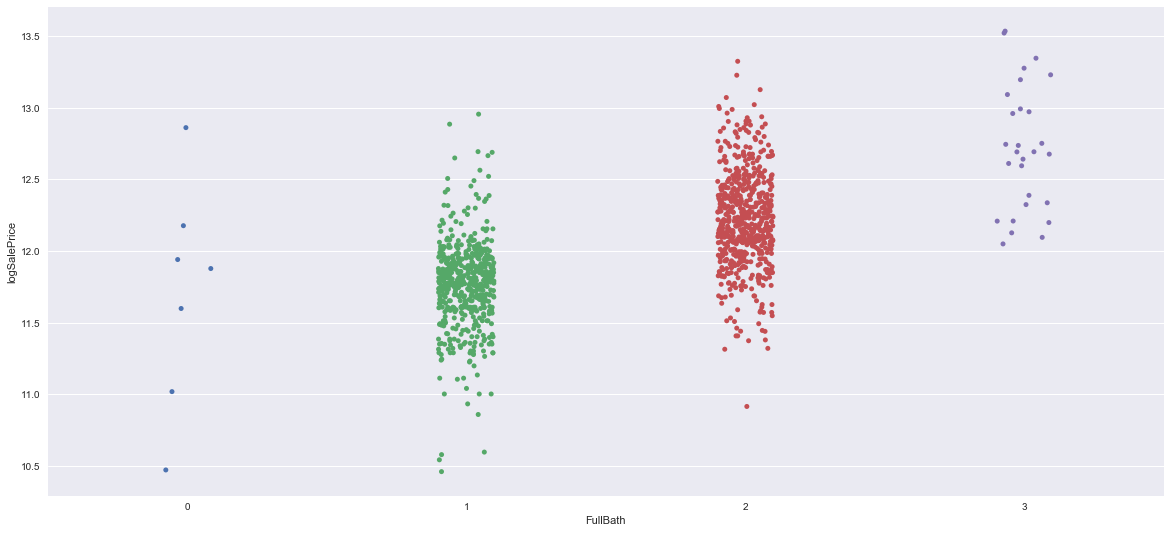

In [101]:
sns.stripplot(x=df_train.FullBath, y=df_train.logSalePrice, jitter=True);

In [102]:
IndexesToClean['FullBath'] = {'outliers':[31, 496, 534, 969, 706, 917]}

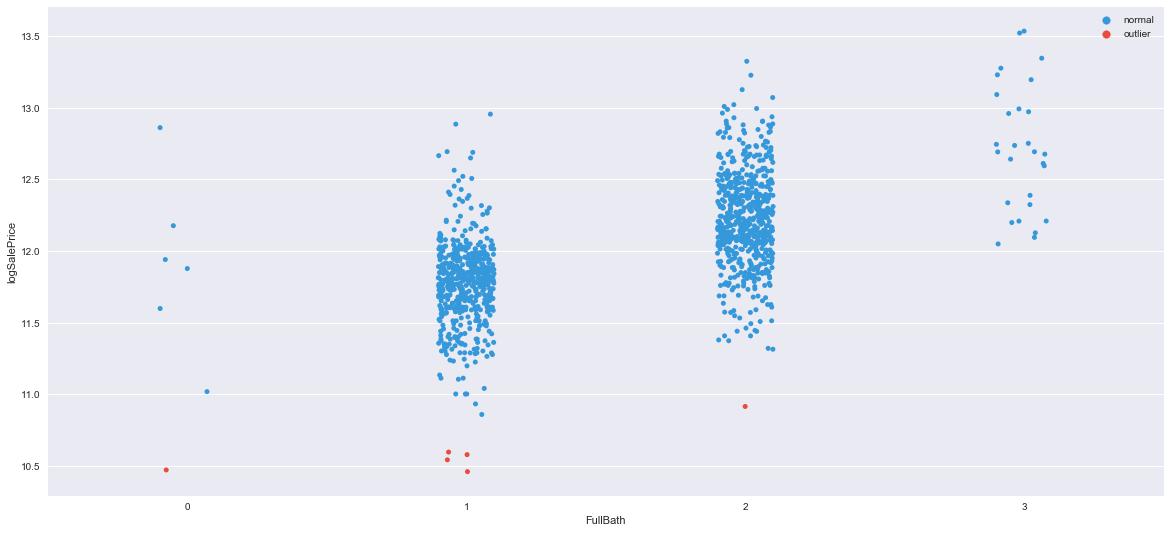

In [103]:
hue=['normal']*df_train.shape[0]
for i in IndexesToClean['FullBath']['outliers'] :
    hue[i-1]='outlier'
sns.stripplot(x=df_train.FullBath, y=df_train.logSalePrice, hue=hue, jitter=True, palette=["#3498db", "#e74c3c"]);

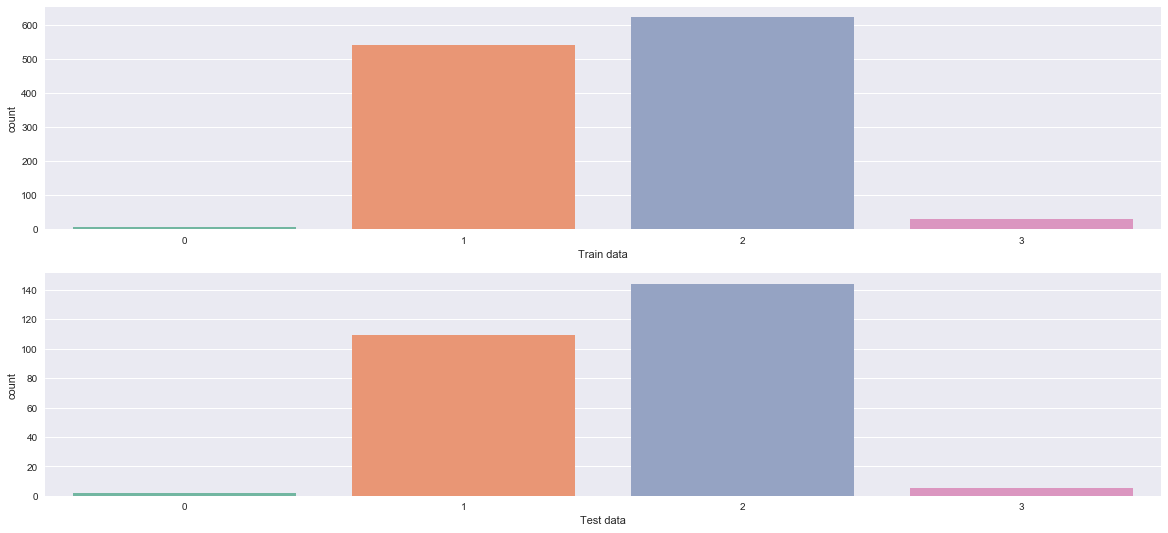

In [104]:
f, axarr = plt.subplots(2, sharex=False)
sns.countplot(x="FullBath", data=df_train, ax=axarr[0], palette=palette);
axarr[0].set_xlabel(xlabel="Train data")
sns.countplot(x="FullBath", data=df_test, ax=axarr[1], palette=palette);
axarr[1].set_xlabel('Test data');

<div class="alert alert-success">

__OBSERVATION__

We have some identic distribution we are very happy with that !
</div>

In [105]:
df.columns.to_series().groupby(df.dtypes).groups[np.dtype('O')]

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object')

### Neighborhood

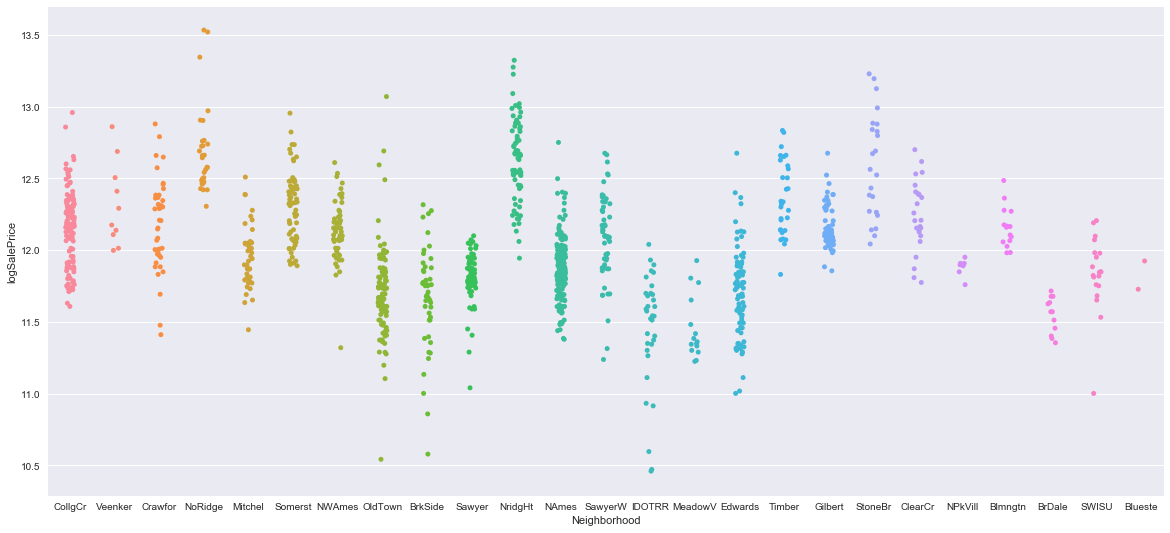

In [106]:
sns.stripplot(x=df_train.Neighborhood, y=df_train.logSalePrice, jitter=True);

In [137]:
IndexesToClean['Neighborhood'] = {'outliers':[113, 1143, 439, 515, 692,1170, 1183, 1132, 633, 969, 534, 711, 463, 643, 342, 384, 31, 496, 917, 725, 945, 1101, 186]}

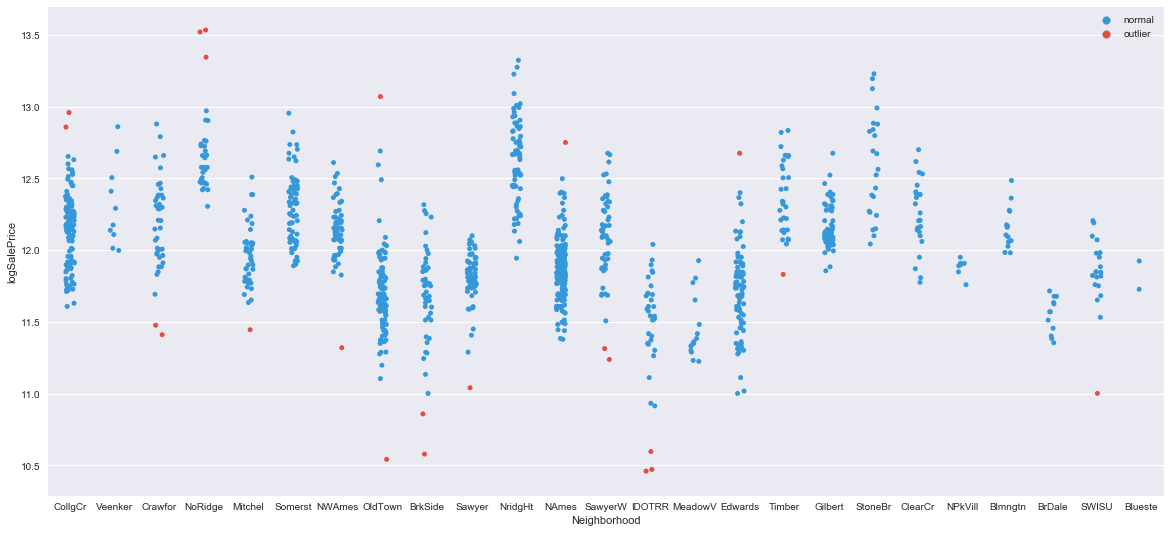

In [138]:
hue=['normal']*df_train.shape[0]
for i in IndexesToClean['Neighborhood']['outliers'] :
    hue[i-1]='outlier'
sns.stripplot(x=df_train.Neighborhood, y=df_train.logSalePrice, hue=hue, jitter=True, palette=["#3498db", "#e74c3c"]);

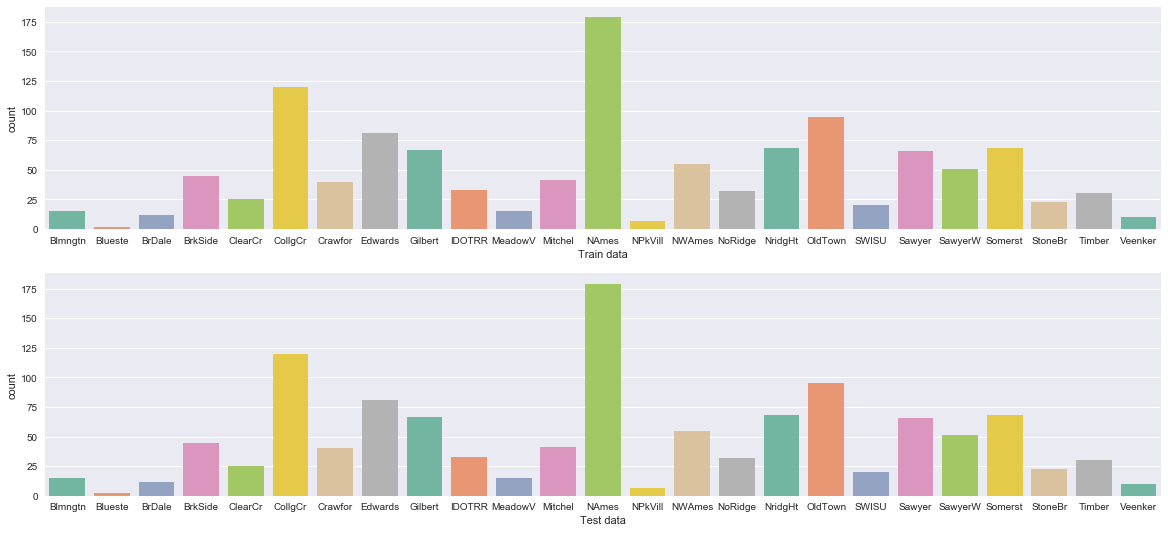

In [112]:
palette2 = sns.palette = sns.color_palette("Set2", 30)
f, axarr = plt.subplots(2, sharex=False)
sns.countplot(x=df_train.Neighborhood.sort_values(), ax=axarr[0], palette=palette2);
axarr[0].set_xlabel(xlabel="Train data")
sns.countplot(x=df_train.Neighborhood.sort_values(), ax=axarr[1], palette=palette2);
axarr[1].set_xlabel('Test data');

<div class="alert alert-success">

__OBSERVATION__

We have some identic distribution we are very happy with that !
</div>

## Outliers

We have been tracking the outliers for some of the features thanks to our dictionnary. Now we will see which one we can safetly delete.

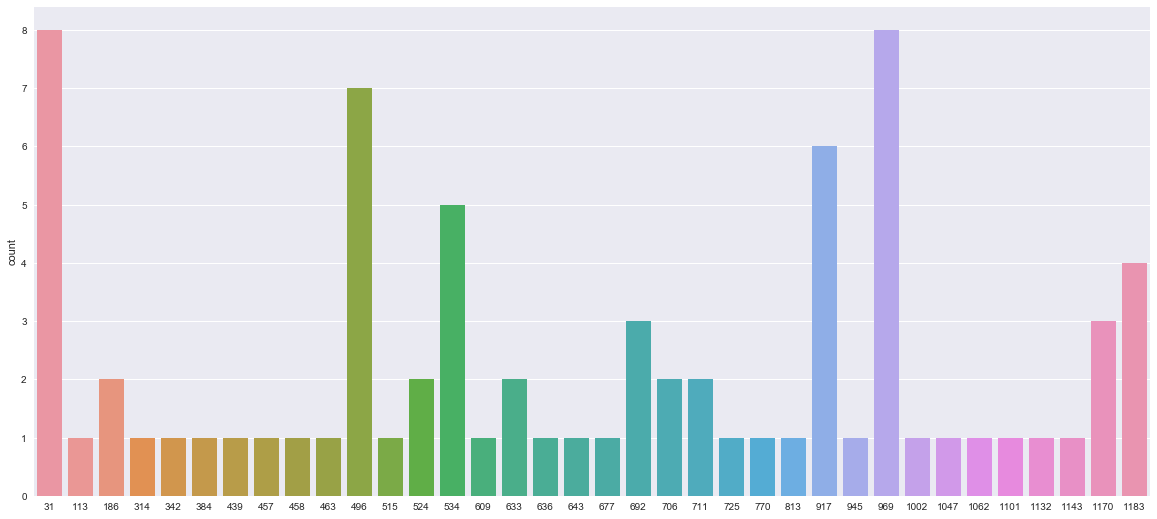

In [174]:
outliers  = list(itertools.chain(*[IndexesToClean[k]['outliers'] for k in IndexesToClean.keys()]))
sns.countplot(x=outliers);

We can safetly delete rows number 31, 496, 917, 969, 1183. This represent 0.4% of the dataset.

## Deleting highly correlated features

Correlation plot


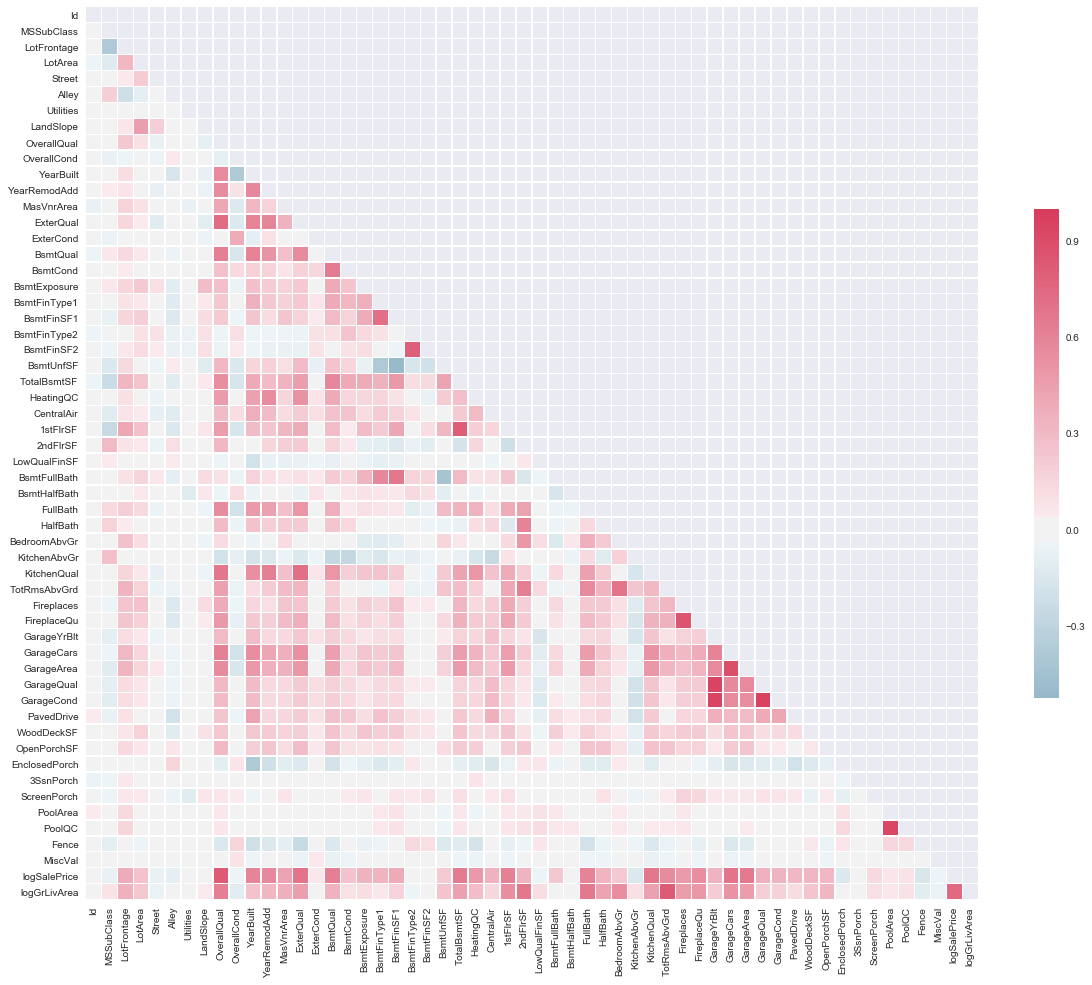

In [175]:
plotCorrelation(df_train)

We have highly correlated columns in the dataset, such as PoolArea and PoolQC or GarageCond and GarageQual. We will determine the most correlated columns and delete non necessary columns.

In [198]:
corr = df.corr()
threshold = 0.85
for c in corr.columns :
    for cc in corr.columns:
        if c == cc:
            continue
        if(corr[c][cc] > threshold):
            print("%s / %s : %f" % (c,cc,corr[c][cc]))

Fireplaces / FireplaceQu : 0.863241
FireplaceQu / Fireplaces : 0.863241
GarageYrBlt / GarageQual : 0.946629
GarageYrBlt / GarageCond : 0.949411
GarageCars / GarageArea : 0.882475
GarageArea / GarageCars : 0.882475
GarageQual / GarageYrBlt : 0.946629
GarageQual / GarageCond : 0.959172
GarageCond / GarageYrBlt : 0.949411
GarageCond / GarageQual : 0.959172
PoolArea / PoolQC : 0.937057
PoolQC / PoolArea : 0.937057


In [208]:
df_train.corr().logSalePrice.sort_values(ascending=False)

logSalePrice     1.000000
OverallQual      0.818680
logGrLivArea     0.745601
GarageCars       0.681809
ExterQual        0.679259
KitchenQual      0.669033
GarageArea       0.651121
TotalBsmtSF      0.641615
BsmtQual         0.616725
1stFlrSF         0.610721
FullBath         0.607066
YearBuilt        0.590738
YearRemodAdd     0.573284
TotRmsAbvGrd     0.554775
FireplaceQu      0.544050
HeatingQC        0.485021
Fireplaces       0.482342
MasVnrArea       0.432964
BsmtFinSF1       0.391919
LotFrontage      0.380234
GarageQual       0.353705
CentralAir       0.350511
BsmtExposure     0.346342
2ndFlrSF         0.342669
GarageCond       0.342215
GarageYrBlt      0.341269
BsmtFinType1     0.338165
HalfBath         0.329854
WoodDeckSF       0.326965
OpenPorchSF      0.321166
PavedDrive       0.319538
BsmtCond         0.266368
LotArea          0.257998
BsmtFullBath     0.229916
BedroomAbvGr     0.223166
BsmtUnfSF        0.215729
ScreenPorch      0.127515
PoolQC           0.080994
PoolArea    

We will keep PoolQC over PoolArea because quality seems more important than Area. For the garage we will keep GarageCond because the train and test data is more similar for this feature than for GarageQual and the year is not something we want to keep. Fireplaces are much more tricky since the number of fireplace and the quality distribution is in both case very similar between the test and train data. We decided to keep FireplacesQC because it is more correlated with logSalePrice. For the same resons we kept GarageCars over GarageArea.

In [196]:
ColumnsToDelete = ['PoolArea', 'GarageQual', 'GarageYrBlt', 'Fireplaces', 'GarageArea']

## Transform into dummies

<div class="alert alert-info">

We still have some categorical features and later on we will want do some regression.

To solve this issue we are going to use pd.get_dummies than allows us to transform those categorial features into numercal ones.
</div>

In [103]:
logSalePrice = df_train.logSalePrice

df_dummies = pd.get_dummies(df)
df_train_d = df_dummies[:len(df_train)]
df_test_d = df_dummies[len(df_train):]
df_train_t = logSalePrice

## Feature Selection

<div class="alert alert-info">

Here the idea is to fit a lasso regression(regression method from sklearn) to d_train_d and d_train_t to obtain the __ Feature importance__ in order to do some feature selection

</div>

In [225]:
lasso= Lasso(alpha=0.0004)
lasso.fit(df_train_d,df_train_t)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [229]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=df_train_d.columns)
#FI_lasso.sort_values("Feature Importance",ascending=False)

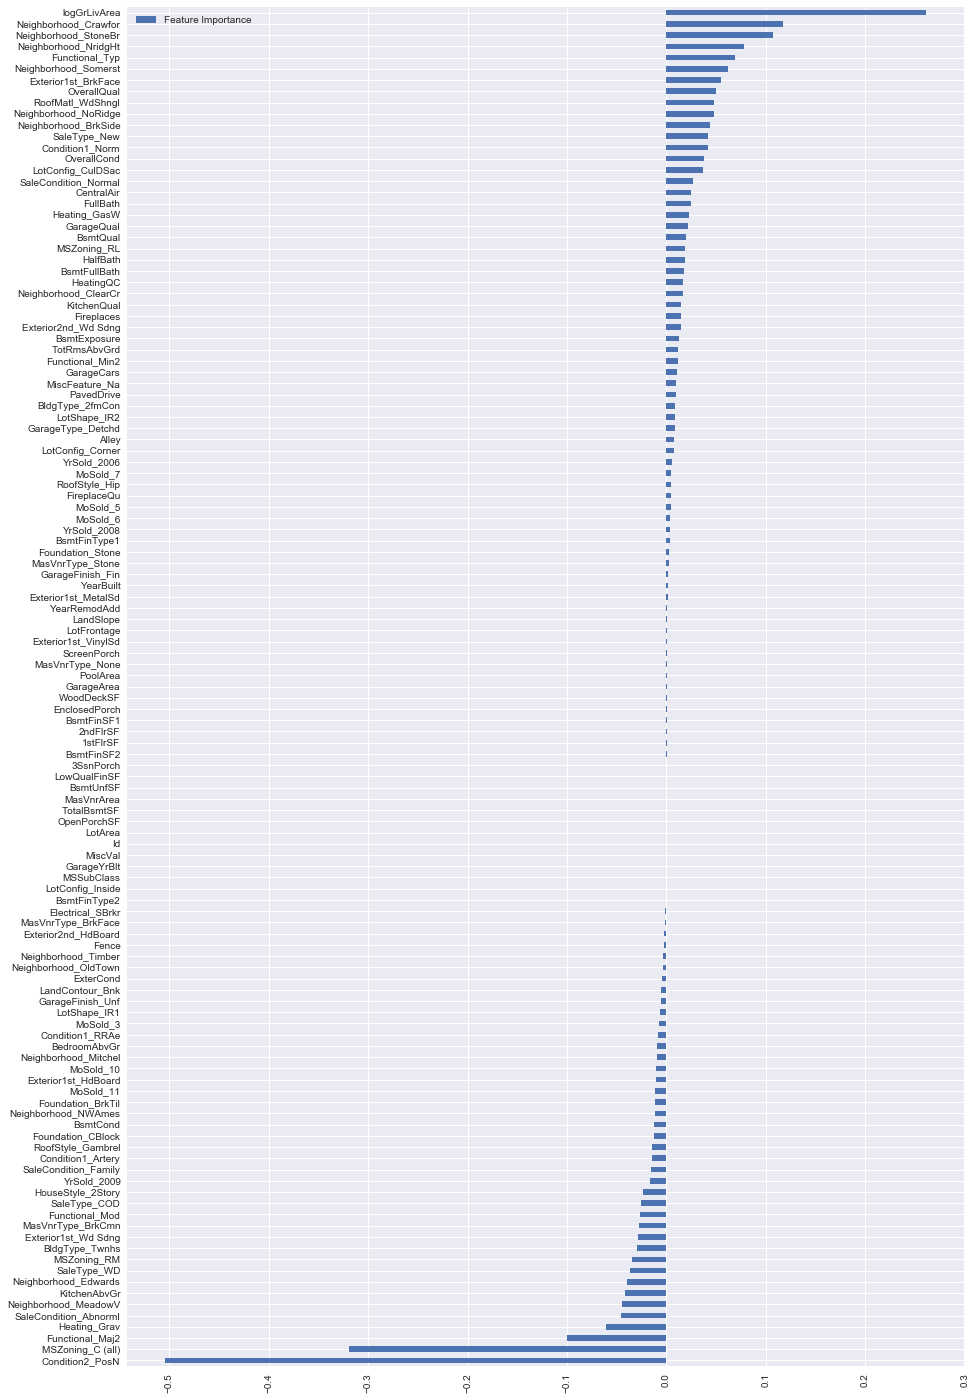

In [230]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

## Adding some new features

<div class="alert alert-info">

Now that we have an idea of the importance we can try adding some features by adding existing one.
Eventhough they are very correlated by doing PCA afterwards we will solve this issue

</div>